In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For loading data
import json

# For loading local modules
import sys
sys.path.append('src')
import analysis
import m3code
import models

# For i/o paths
import os.path

# For map visualization
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import mapviz

# For manipulating colors
import matplotlib.colors as mplcolors

# For manipulating lines
from matplotlib.collections import LineCollection
import matplotlib.lines as mlines

# For checking figure size
import matplotlib.patches as mpatches

import scipy.stats

In [20]:
from matplotlib import font_manager
import unicodedata

FONTS_DIR = 'ipaexg00401'
font_dirs = [FONTS_DIR]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for fpath in font_files:
    font_manager.fontManager.addfont(fpath)

plt.rcParams['font.family'] = ['sans-serif', 'serif', 'IPAexGothic']
plt.rcParams["font.sans-serif"] = ['Helvetica']
plt.rcParams['font.serif'] = ['Palatino']
SMALL_FONT_SIZE = 8
MEDIUM_FONT_SIZE = 9
LARGE_FONT_SIZE = 12.5
PANEL_LABEL_SIZE = 16
PANEL_LABEL_FONT = 'DejaVu Sans'
plt.rcParams.update({'font.size': MEDIUM_FONT_SIZE})

In [21]:
paramf = '../scratch/paramf.json'
with open(paramf) as f:
    params = json.load(f)

with open(params['path_to_qfdict_json']) as f:
    qfdict = json.load(f)
exception = ['東京都']
for ex in exception:
    del qfdict[ex]
path_to_preprocessed_dir = params['path_to_preprocessed_dir']
path_to_sig_dir = params['path_to_sig_dir']
all_file = params['all_file']
figdir = '../scratch/figure'

with open('../scratch/file_name_list_commonnoun.json') as f:
    qfdict_commonnoun = json.load(f)

with open('../scratch/file_name_list_abroad.json') as f:
    qfdict_abroad = json.load(f)

In [22]:
pop_center_df_dict = pd.read_excel('../original/population/population_center_2020.xlsx', 
                              sheet_name=None, engine='openpyxl', skiprows=1, 
                              dtype={'コード': str})

In [23]:
pop_center_df = pd.DataFrame()
for df in pop_center_df_dict.values():
    pop_center_df = pd.concat([pop_center_df, df])

pop_center_df = pop_center_df.drop_duplicates(subset='コード')\
    .rename(columns={'コード': 'code', '名称': 'name', '10進緯度': 'lat', '10進経度': 'lon', '人口': 'pop'})\
    .set_index('code')
    # .reset_index(drop=True)

pop_center_df

name         lon        lat          pop
code                                           
00000    全国  137.055679  35.567677  126146099.0
01000   北海道  141.868271  43.077839    5224614.0
02000   青森県  140.925997  40.708556    1237984.0
03000   岩手県  141.283812  39.508464    1210534.0
04000   宮城県  140.954148  38.335535    2301996.0
...     ...         ...        ...          ...
47361  久米島町  126.773735  26.346231          NaN
47362  八重瀬町  127.726169  26.149029          NaN
47375  多良間村  124.703130  24.669191          NaN
47381   竹富町  123.870143  24.313570          NaN
47382  与那国町  122.979943  24.459122          NaN

[1966 rows x 4 columns]

In [24]:
pref_name2code = pop_center_df[pop_center_df.index.str.endswith('000')]['name']\
    .str.replace('都$|府$|県$', '', regex=True)
pref_name2code = dict(zip(pref_name2code, pref_name2code.index))
pref_name2code

{'全国': '00000',
 '北海道': '01000',
 '青森': '02000',
 '岩手': '03000',
 '宮城': '04000',
 '秋田': '05000',
 '山形': '06000',
 '福島': '07000',
 '茨城': '08000',
 '栃木': '09000',
 '群馬': '10000',
 '埼玉': '11000',
 '千葉': '12000',
 '東京': '13000',
 '神奈川': '14000',
 '新潟': '15000',
 '富山': '16000',
 '石川': '17000',
 '福井': '18000',
 '山梨': '19000',
 '長野': '20000',
 '岐阜': '21000',
 '静岡': '22000',
 '愛知': '23000',
 '三重': '24000',
 '滋賀': '25000',
 '京都': '26000',
 '大阪': '27000',
 '兵庫': '28000',
 '奈良': '29000',
 '和歌山': '30000',
 '鳥取': '31000',
 '島根': '32000',
 '岡山': '33000',
 '広島': '34000',
 '山口': '35000',
 '徳島': '36000',
 '香川': '37000',
 '愛媛': '38000',
 '高知': '39000',
 '福岡': '40000',
 '佐賀': '41000',
 '長崎': '42000',
 '熊本': '43000',
 '大分': '44000',
 '宮崎': '45000',
 '鹿児島': '46000',
 '沖縄': '47000'}

In [25]:
all_df = analysis.read_sig_file(path_to_sig_dir, all_file)
all_df[['latitude', 'longitude']] = m3code.latlon(all_df)

The columns "m3code" are unique: True


In [26]:
def sum_stat_dict(stat, qfdict, path_to_preprocessed_dir):
    sum_stats = {}
    for query, qfile in qfdict.items():
        try:
            df = pd.read_csv(os.path.join(path_to_preprocessed_dir, qfile), 
                             index_col=0, dtype={'m3code':str})
            sum_stats[query] = df[stat].sum()
        except:
            print("no file for:", query)
    print('top toponyms:', sorted(sum_stats.items(), key=lambda kv: kv[1])[-1:-51:-1])
    return sum_stats

In [27]:
stat = 'tweetcount'
sum_tweetcount = sum_stat_dict(stat=stat, qfdict=qfdict, path_to_preprocessed_dir=path_to_preprocessed_dir)

no file for: 南アルプス
no file for: つくば
no file for: 新ひだか
no file for: ふじみ野
no file for: みどり
top toponyms: [('東京', np.int64(1824122)), ('大阪', np.int64(1054970)), ('京都', np.int64(595184)), ('名古屋', np.int64(541652)), ('横浜', np.int64(497144)), ('渋谷', np.int64(467935)), ('新宿', np.int64(465470)), ('福岡', np.int64(400244)), ('沖縄', np.int64(349830)), ('広島', np.int64(296379)), ('仙台', np.int64(282107)), ('神戸', np.int64(275723)), ('北海道', np.int64(268857)), ('札幌', np.int64(266909)), ('富士', np.int64(262489)), ('千葉', np.int64(240355)), ('新潟', np.int64(199016)), ('関西', np.int64(195198)), ('博多', np.int64(182049)), ('静岡', np.int64(180166)), ('埼玉', np.int64(165630)), ('中国', np.int64(164492)), ('岡山', np.int64(157568)), ('福島', np.int64(155436)), ('長野', np.int64(144254)), ('熊本', np.int64(144240)), ('秋葉', np.int64(139493)), ('川崎', np.int64(139272)), ('上野', np.int64(137406)), ('奈良', np.int64(134690)), ('鹿児島', np.int64(125883)), ('長崎', np.int64(122960)), ('九州', np.int64(119706)), ('大分', np.int64(119359)), ('

In [28]:
with open('../original/regions.txt') as f:
    regions = [s.strip() for s in f.readlines()]

sorted([(region, sum_tweetcount[region]) for region in regions], key=lambda x: x[1], reverse=True)[:10]

[('関西', np.int64(195198)),
 ('中国', np.int64(164492)),
 ('九州', np.int64(119706)),
 ('関東', np.int64(118318)),
 ('東北', np.int64(117442)),
 ('東海', np.int64(113084)),
 ('多摩', np.int64(66404)),
 ('四国', np.int64(41803)),
 ('北陸', np.int64(32148)),
 ('東日本', np.int64(28350))]

In [29]:
region_names = [('東北', 'Tohoku'), ('関東', 'Kanto'), ('東海','Tokai'), ('関西', 'Kansai'), 
                ('四国', 'Shikoku'), ('九州', 'Kyushu')]

In [30]:
shpfile_province = shpreader.natural_earth(resolution='10m', category='cultural', 
                                           name='admin_1_states_provinces')
pref_shape_dict = {province.attributes['name'].translate(str.maketrans({'Ō': 'O', 'ō' : 'o'})): province.geometry 
                   for province in shpreader.Reader(shpfile_province).records()
                   if province.attributes['admin'] == 'Japan'}
print('Number of prefectures:', len(pref_shape_dict))

Number of prefectures: 47


In [31]:
region_to_pref_dict = {
    '東北': [('青森', 'Aomori'), ('岩手', 'Iwate'), ('宮城', 'Miyagi'), ('秋田', 'Akita'), 
           ('山形', 'Yamagata'), ('福島', 'Fukushima')], 
    '関東': [('東京', 'Tokyo'), ('神奈川', 'Kanagawa'), ('埼玉', 'Saitama'), ('千葉', 'Chiba'), 
           ('茨城', 'Ibaraki'), ('栃木', 'Tochigi'), ('群馬', 'Gunma')],
    '東海': [('愛知', 'Aichi'), ('三重', 'Mie'), ('岐阜', 'Gifu'), ('静岡', 'Shizuoka')],
    '関西': [('大阪', 'Osaka'), ('京都', 'Kyoto'), ('兵庫', 'Hyogo'), ('奈良', 'Nara'), 
           ('滋賀', 'Shiga'), ('和歌山', 'Wakayama')],
    '四国': [('愛媛', 'Ehime'), ('香川', 'Kagawa'), ('徳島', 'Tokushima'), ('高知', 'Kochi')],
    '九州': [('福岡', 'Fukuoka'), ('佐賀', 'Saga'), ('長崎', 'Nagasaki'), ('熊本', 'Kumamoto'),
           ('大分', 'Oita'), ('宮崎', 'Miyazaki'), ('鹿児島', 'Kagoshima')]
}

region_shape_dict = {region: [pref_shape_dict[pref[1]] for pref in prefs] 
                     for region, prefs in region_to_pref_dict.items()}

def calc_region_pop_center(pref_codes, pop_center_df):
    pop_center = pop_center_df[pop_center_df.index.isin(pref_codes)]
    pop = pop_center['pop'].sum()
    lat = (pop_center['lat'] * pop_center['pop']).sum() / pop
    lon = (pop_center['lon'] * pop_center['pop']).sum() / pop
    return lat, lon

region_coords = {region: calc_region_pop_center([pref_name2code[pref[0]] for pref in prefs], pop_center_df) 
                 for region, prefs in region_to_pref_dict.items()}
region_coords

{'東北': (np.float64(38.806861833315004), np.float64(140.7159388588153)),
 '関東': (np.float64(35.77800020965544), np.float64(139.69500726549785)),
 '東海': (np.float64(35.058550268449906), np.float64(137.24829468334957)),
 '関西': (np.float64(34.74074521520803), np.float64(135.47195960379358)),
 '四国': (np.float64(33.908103066147106), np.float64(133.57556536700574)),
 '九州': (np.float64(32.95636356414874), np.float64(130.62544181578875))}

In [32]:
pref_name_cand = [('岩手', 'Iwate'), ('宮城', 'Miyagi'), ('茨城', 'Ibaraki'), ('群馬', 'Gunma'), 
                  ('石川', 'Ishikawa'), ('山梨', 'Yamanashi'), ('愛知', 'Aichi'), ('三重', 'Mie'), 
                  ('滋賀', 'Shiga'), ('島根', 'Shimane'), ('香川', 'Kagawa'), ('愛媛', 'Ehime')]
sorted([(pref[0], sum_tweetcount.get(pref[0], 0)) for pref in pref_name_cand], 
       key=lambda x: x[1], reverse=True)

[('愛知', np.int64(114449)),
 ('群馬', np.int64(96397)),
 ('茨城', np.int64(86212)),
 ('石川', np.int64(84577)),
 ('香川', np.int64(82464)),
 ('三重', np.int64(81143)),
 ('滋賀', np.int64(75955)),
 ('宮城', np.int64(73894)),
 ('山梨', np.int64(69406)),
 ('岩手', np.int64(63029)),
 ('愛媛', np.int64(52561)),
 ('島根', np.int64(31856))]

In [33]:
pref_names = [('愛知', 'Aichi'), ('群馬', 'Gunma'), ('石川', 'Ishikawa'), ('香川', 'Kagawa'), 
              ('滋賀', 'Shiga'), ('宮城', 'Miyagi')]


In [34]:

pref_coords = {pref[0]: pop_center_df.loc[pref_name2code[pref[0]], ['lat', 'lon']].tolist() 
               for pref in pref_names}
pref_coords

{'愛知': [np.float64(35.087069), np.float64(137.000762)],
 '群馬': [np.float64(36.358046), np.float64(139.14162)],
 '石川': [np.float64(36.618845), np.float64(136.643888)],
 '香川': [np.float64(34.277957), np.float64(133.964311)],
 '滋賀': [np.float64(35.11088), np.float64(136.066973)],
 '宮城': [np.float64(38.335535), np.float64(140.954148)]}

In [35]:
city_names = [('京都', 'Kyoto'), ('名古屋', 'Nagoya'), ('福岡', 'Fukuoka'), ('広島', 'Hiroshima'), 
              ('仙台', 'Sendai'), ('札幌', 'Sapporo')]


In [36]:
city_name2code = {'京都': '26100', '名古屋': '23100', '福岡': '40130', '広島': '34100', 
                  '仙台': '04100', '札幌': '01100'}
city_coords = {city[0]: pop_center_df.loc[city_name2code[city[0]], ['lat', 'lon']].tolist() 
               for city in city_names}
city_coords

{'京都': [np.float64(34.995358), np.float64(135.749704)],
 '名古屋': [np.float64(35.149729), np.float64(136.928594)],
 '福岡': [np.float64(33.585063), np.float64(130.389985)],
 '広島': [np.float64(34.417033), np.float64(132.457575)],
 '仙台': [np.float64(38.268849), np.float64(140.877283)],
 '札幌': [np.float64(43.064821), np.float64(141.359064)]}

In [37]:
shpfile_mea = '../original/japan_MetropolitanEmploymentArea2015map/' +\
    'japan_MetropolitanEmploymentArea2015map.shp'
mea_shape_dict = {mea.attributes['MEA_Name']: mea.geometry 
                  for mea in shpreader.Reader(shpfile_mea).records()}
print('Number of MEAs:', len(mea_shape_dict))

Number of MEAs: 100


In [38]:
city_name_to_mea_name = {}
for city_name_jp, city_name_en in city_names:
    for mea_name in mea_shape_dict.keys():
        if city_name_en in mea_name:
            print(city_name_jp, mea_name)
            city_name_to_mea_name[city_name_jp] = mea_name
city_shape_dict = {city_name: mea_shape_dict[mea_name] for city_name, mea_name in city_name_to_mea_name.items()}

京都 Kyoto-Kusatsu
名古屋 Nagoya
福岡 Fukuoka
広島 Hiroshima
仙台 Sendai
札幌 Sapporo-Otaru


In [39]:
data_census = pd.read_csv('../original/population/PopulationCensus.csv', dtype={0:str, 2:str, 3:str})
df_census = data_census.rename(columns={'地域識別コード': 'district_type', 
                  '境域年次(2015)': 'district_2015',
                  '境域年次(2000)': 'district_2000',
                  'Unnamed: 4': 'name',
                  '人口　平成27年　(a)': 'population_2015'})

df_census = df_census[['district_type', 'district_2015', 'district_2000', 
                       'name', 'population_2015']]
df_census.fillna({'district_2015': False, 'district_2000': False}, inplace=True)
df_census = df_census.replace({'district_2015': {'2015': True}, 'district_2000': {'2000': True}})

wards = df_census[df_census['district_type'] == "0"]
ward_names = [ward_name.split()[-1][:-1] for ward_name in wards['name'].values]
ward_name_counter = {}
for name in ward_names:
    if name in ward_name_counter:
        ward_name_counter[name] += 1
    else:
        ward_name_counter[name] = 1
unique_ward_names = [name for name, count in ward_name_counter.items() if count <= 2]

sorted([(ward, sum_tweetcount.get(ward, 0)) for ward in unique_ward_names], 
       key=lambda x: x[1], reverse=True)[:20]

/var/folders/4q/mxff29vs1dbfnlqmcxnvqycr0000gp/T/ipykernel_28514/875554596.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_census = df_census.replace({'district_2015': {'2015': True}, 'district_2000': {'2000': True}})


[('渋谷', np.int64(467935)),
 ('新宿', np.int64(465470)),
 ('博多', np.int64(182049)),
 ('福島', np.int64(155436)),
 ('秋葉', np.int64(139493)),
 ('川崎', np.int64(139272)),
 ('金沢', np.int64(112357)),
 ('大宮', np.int64(111819)),
 ('神奈川', np.int64(110353)),
 ('中野', np.int64(109809)),
 ('清水', np.int64(106359)),
 ('目黒', np.int64(97761)),
 ('昭和', np.int64(90938)),
 ('品川', np.int64(85933)),
 ('浦和', np.int64(81762)),
 ('中村', np.int64(78527)),
 ('兵庫', np.int64(70017)),
 ('多摩', np.int64(66404)),
 ('堺', np.int64(49295)),
 ('天王寺', np.int64(48656))]

In [40]:
district_names = [('渋谷', 'Shibuya'), ('新宿', 'Shinjuku'), ('博多', 'Hakata'), ('大宮', 'Omiya'), 
                  ('天王寺', 'Tennoji'), ('世田谷', 'Setagaya')]
district_codes = {'渋谷': '13113', '新宿': '13104', '博多': '40132', '大宮': '11103', 
                  '天王寺': '27109', '世田谷': '13112'}
district_coords = {district: pop_center_df.loc[district_codes[district], ['lat', 'lon']].tolist() 
                   for district, _ in district_names}
district_coords

{'渋谷': [np.float64(35.668376), np.float64(139.692787)],
 '新宿': [np.float64(35.703335), np.float64(139.708761)],
 '博多': [np.float64(33.579757), np.float64(130.434872)],
 '大宮': [np.float64(35.906252), np.float64(139.622015)],
 '天王寺': [np.float64(34.661313), np.float64(135.521817)],
 '世田谷': [np.float64(35.642166), np.float64(139.638761)]}

In [42]:
district_shape_dict = {}
for district_name_jp, district_names_en in district_names:
    shpfile_district = '../original/ward_shapefiles/' + \
        f'A002005532016DDSWC{district_codes[district_name_jp]}-JGD2011/' + \
        f'h28ca{district_codes[district_name_jp]}.shp'
    district_shape_dict[district_names_en] = [quarter.geometry for quarter 
                                              in shpreader.Reader(shpfile_district, encoding='shift-jis').records()]

In [43]:
stat = 'tweetcount'
sum_tweetcount = sum_stat_dict(stat=stat, qfdict=qfdict_commonnoun, 
                               path_to_preprocessed_dir=path_to_preprocessed_dir)

top toponyms: [('仕事', np.int64(2591022)), ('公園', np.int64(907618)), ('高校', np.int64(744703)), ('電話', np.int64(700844)), ('大学', np.int64(675606)), ('カフェ', np.int64(638326)), ('天気', np.int64(622436)), ('家族', np.int64(594793)), ('関係', np.int64(558094)), ('映画', np.int64(541011)), ('旅行', np.int64(462364)), ('ホテル', np.int64(435457)), ('空港', np.int64(386957)), ('病院', np.int64(374283)), ('情報', np.int64(364552)), ('神社', np.int64(323938)), ('音楽', np.int64(290428)), ('野菜', np.int64(229598)), ('社会', np.int64(227110)), ('女性', np.int64(218787)), ('コンビニ', np.int64(199357)), ('スマホ', np.int64(172667)), ('財布', np.int64(157620)), ('田舎', np.int64(155977)), ('理由', np.int64(153446)), ('想像', np.int64(147525)), ('健康', np.int64(140474)), ('美術館', np.int64(124457)), ('時計', np.int64(104087)), ('環境', np.int64(90482)), ('男性', np.int64(83532)), ('図書館', np.int64(82902)), ('政治', np.int64(62812)), ('りんご', np.int64(62183)), ('教科書', np.int64(62011)), ('科学', np.int64(61013)), ('マグロ', np.int64(44406)), ('手袋', np.int64(2

In [44]:
common_nouns_nonspatial = [('電話', 'telephone'), ('音楽', 'music'), ('野菜', 'vegetable'), 
                           ('社会', 'society'), ('財布', 'wallet'), ('理由', 'reason')]
common_nouns_spatial = [('旅行', 'trip'), ('公園', 'park'),  ('大学', 'university'), 
                        ('ホテル', 'hotel'), ('空港', 'airport'), ('神社', 'shrine')]

In [45]:
stat = 'tweetcount'
sum_tweetcount = sum_stat_dict(stat=stat, qfdict=qfdict_abroad, 
                               path_to_preprocessed_dir=path_to_preprocessed_dir)

top toponyms: [('パリ', np.int64(89187)), ('ハワイ', np.int64(71033)), ('ドバイ', np.int64(59253)), ('ソウル', np.int64(55962)), ('ホンコン/香港', np.int64(22872)), ('グアム', np.int64(18998)), ('上海', np.int64(18798)), ('ニューヨーク', np.int64(18268)), ('シンガポール', np.int64(17137)), ('ローマ', np.int64(16956)), ('ロンドン', np.int64(16443)), ('カイロ', np.int64(16155)), ('北京', np.int64(11786)), ('デリー', np.int64(11378)), ('ボストン', np.int64(10820)), ('ミラノ', np.int64(8545)), ('ウィーン', np.int64(8384)), ('ワシントン', np.int64(6063)), ('台北', np.int64(5635)), ('フランクフルト', np.int64(5275)), ('バンコク', np.int64(5170)), ('バルセロナ', np.int64(4294)), ('ホノルル', np.int64(4274)), ('デリー2', np.int64(3977)), ('シカゴ', np.int64(3479)), ('ミュンヘン', np.int64(3450)), ('バンクーバー', np.int64(3243)), ('マドリード', np.int64(3158)), ('ロサンゼルス', np.int64(3119)), ('ベルリン', np.int64(3113)), ('サンフランシスコ', np.int64(2932)), ('ウィーン2', np.int64(2921)), ('シドニー', np.int64(2440)), ('サイパン', np.int64(2295)), ('モスクワ', np.int64(1851)), ('ジャカルタ', np.int64(1751)), ('ワイキ

In [46]:
abroad_names = [('ハワイ', 'Hawaii'), ('ドバイ', 'Dubai'), ('ホンコン/香港', 'Hong Kong'), 
                ('ニューヨーク', 'New York'), ('シンガポール', 'Singapore'),  ('ソウル', 'Seoul')]

In [47]:
list_of_keywords = region_names + pref_names + city_names + district_names + common_nouns_nonspatial + common_nouns_spatial + abroad_names

In [48]:
list_of_keywords

[('東北', 'Tohoku'),
 ('関東', 'Kanto'),
 ('東海', 'Tokai'),
 ('関西', 'Kansai'),
 ('四国', 'Shikoku'),
 ('九州', 'Kyushu'),
 ('愛知', 'Aichi'),
 ('群馬', 'Gunma'),
 ('石川', 'Ishikawa'),
 ('香川', 'Kagawa'),
 ('滋賀', 'Shiga'),
 ('宮城', 'Miyagi'),
 ('京都', 'Kyoto'),
 ('名古屋', 'Nagoya'),
 ('福岡', 'Fukuoka'),
 ('広島', 'Hiroshima'),
 ('仙台', 'Sendai'),
 ('札幌', 'Sapporo'),
 ('渋谷', 'Shibuya'),
 ('新宿', 'Shinjuku'),
 ('博多', 'Hakata'),
 ('大宮', 'Omiya'),
 ('天王寺', 'Tennoji'),
 ('世田谷', 'Setagaya'),
 ('電話', 'telephone'),
 ('音楽', 'music'),
 ('野菜', 'vegetable'),
 ('社会', 'society'),
 ('財布', 'wallet'),
 ('理由', 'reason'),
 ('旅行', 'trip'),
 ('公園', 'park'),
 ('大学', 'university'),
 ('ホテル', 'hotel'),
 ('空港', 'airport'),
 ('神社', 'shrine'),
 ('ハワイ', 'Hawaii'),
 ('ドバイ', 'Dubai'),
 ('ホンコン/香港', 'Hong Kong'),
 ('ニューヨーク', 'New York'),
 ('シンガポール', 'Singapore'),
 ('ソウル', 'Seoul')]

In [26]:
# Territorial extreme points
# east_ext = mapviz.dms_to_dd((153, 59, 12))
# west_ext = mapviz.dms_to_dd((122, 55, 57))
# south_ext = mapviz.dms_to_dd((20, 25, 31))
# north_ext = mapviz.dms_to_dd((45, 33, 26))

# Reachable extreme points
east_ext = mapviz.dms_to_dd((145, 48, 58))
west_ext = mapviz.dms_to_dd((122, 56, 1))
south_ext = mapviz.dms_to_dd((24, 2, 59))
north_ext = mapviz.dms_to_dd((45, 31, 22))

center_lon = mapviz.dms_to_dd((139, 44, 28))
center_lat = mapviz.dms_to_dd((35, 39, 29))
lon_diff = east_ext - west_ext
lat_diff = north_ext - south_ext
extent = (west_ext-lon_diff*0.05, east_ext+lon_diff*0.05, south_ext-lat_diff*0.05, north_ext+lat_diff*0.05)
res = '50m'

lambert_area_proj = ccrs.LambertAzimuthalEqualArea(
    central_longitude=center_lon, 
    central_latitude=center_lat)

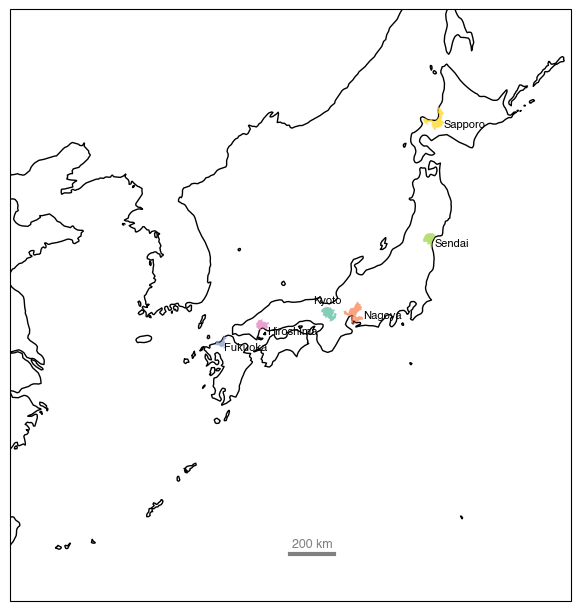

In [27]:
fig = plt.figure(figsize=(6, 6), layout='constrained')
map_data = mapviz.MapVisualizer(fig, extent=extent, projection=lambert_area_proj)
cmap = plt.get_cmap('Set2')
# colors = [cmap(i) for i in np.linspace(0, 1, len(city_names))]
colors = [cmap(i) for i in range(len(city_names))]
text_offset = {'京都': (-0.9, 0.5), '名古屋': (0.5, -0.2), '福岡': (0.2, -0.3),
               '広島': (0.2, -0.3), '仙台': (0.2, -0.3), '札幌': (0.3, -0.2)}
for i, (city_name_jp, city_name_en) in enumerate(city_names):
    shape_feature = cfeature.ShapelyFeature(
        city_shape_dict[city_name_jp], ccrs.PlateCarree(), 
        linewidth=0.2, facecolor=colors[i], edgecolor='none', alpha=0.8)
    map_data.ax.add_feature(shape_feature)
    map_data.ax.text(city_coords[city_name_jp][1]+text_offset[city_name_jp][0], 
                     city_coords[city_name_jp][0]+text_offset[city_name_jp][1], 
                     city_name_en, transform=ccrs.PlateCarree(), fontsize=8, color='black')
fig.set_frameon(False)
mapviz.scale_bar(ax=map_data.ax, location=(0.5, 0.08), length=200, color='grey')

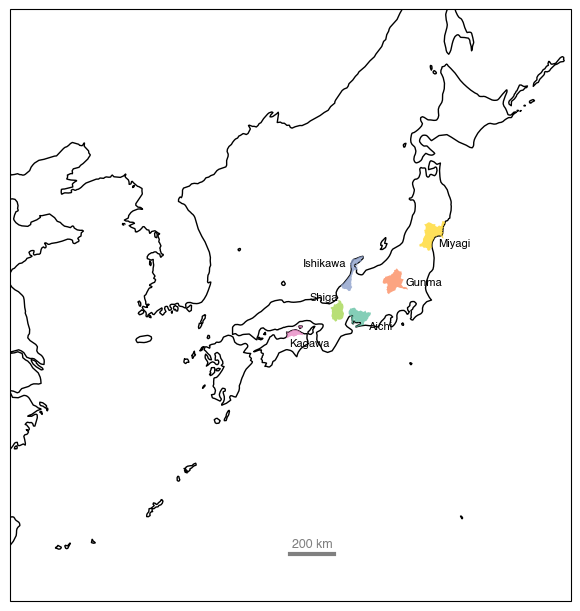

In [28]:
fig = plt.figure(figsize=(6, 6), layout='constrained')
map_data = mapviz.MapVisualizer(fig, extent=extent, projection=lambert_area_proj)
cmap = plt.get_cmap('Set2')
# colors = [cmap(i) for i in np.linspace(0, 1, len(city_names))]
colors = [cmap(i) for i in range(len(pref_names))]
text_offset = {'愛知': (0.7, -0.6), '群馬': (0.4, 0), '石川': (-2.4, 0.4), 
               '香川': (-0.2, -0.6), '滋賀': (-1.4, 0.5), '宮城': (0.3, -0.4)}
for i, (pref_name_jp, pref_name_en) in enumerate(pref_names):
    shape_feature = cfeature.ShapelyFeature(
        pref_shape_dict[pref_name_en], ccrs.PlateCarree(), 
        linewidth=0.2, facecolor=colors[i], edgecolor='none', alpha=0.8)
    map_data.ax.add_feature(shape_feature)
    map_data.ax.text(pref_coords[pref_name_jp][1]+text_offset[pref_name_jp][0], 
                     pref_coords[pref_name_jp][0]+text_offset[pref_name_jp][1], 
                     pref_name_en, transform=ccrs.PlateCarree(), fontsize=8, color='black')
fig.set_frameon(False)
mapviz.scale_bar(ax=map_data.ax, location=(0.5, 0.08), length=200, color='grey')

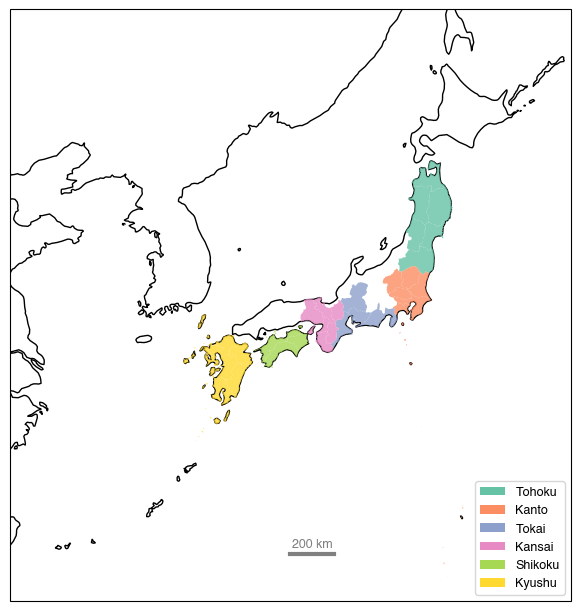

In [29]:
fig = plt.figure(figsize=(6, 6), layout='constrained')
map_data = mapviz.MapVisualizer(fig, extent=extent, projection=lambert_area_proj)
cmap = plt.get_cmap('Set2')
# colors = [cmap(i) for i in np.linspace(0, 1, len(city_names))]
colors = [cmap(i) for i in range(len(region_names))]
for i, (region_name_jp, region_name_en) in enumerate(region_names):
    shape_feature = cfeature.ShapelyFeature(
        region_shape_dict[region_name_jp], ccrs.PlateCarree(), 
        linewidth=0, facecolor=colors[i], edgecolor='none', alpha=0.8)
    map_data.ax.add_feature(shape_feature)
fig.set_frameon(False)
mapviz.scale_bar(ax=map_data.ax, location=(0.5, 0.08), length=200, color='grey')
map_data.ax.legend([plt.Rectangle((0,0),1,1,fc=colors[i]) for i in range(len(region_names))], 
                   [name_en for _, name_en in region_names], loc='lower right')

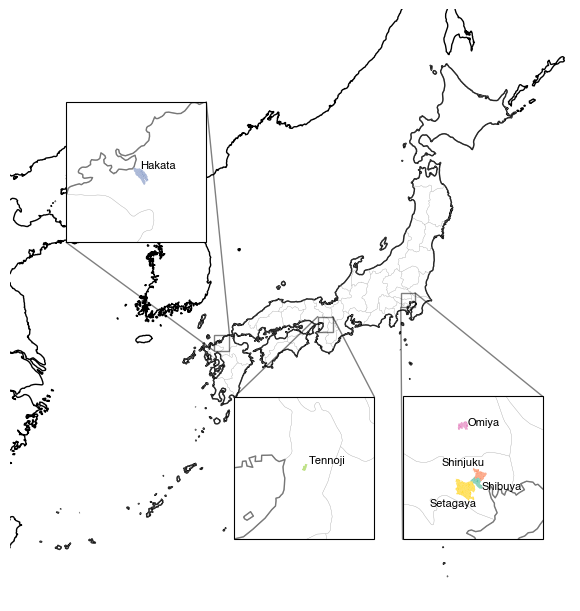

In [28]:
fig = plt.figure(figsize=(6, 6), layout='constrained')
map_data = mapviz.MapVisualizer(fig, extent=extent, projection=lambert_area_proj, resolution='10m')
# map_data.ax.add_feature(cfeature.LAND)
for pref_name_en, pref_geom in pref_shape_dict.items():
    shape_feature = cfeature.ShapelyFeature(pref_geom, ccrs.PlateCarree(),
                                linewidth=0.2, facecolor='none', edgecolor='darkgrey', alpha=0.8)
    map_data.ax.add_feature(shape_feature)
cmap = plt.get_cmap('Set2')
colors = [cmap(i) for i in range(len(region_names))]
text_offset = {'渋谷': (0.02, -0.02), '新宿': (-0.2, 0.04), 
               '博多': (0.02, 0.02), '大宮': (0.02, 0), 
               '天王寺': (0.02, 0.02), '世田谷': (-0.2, -0.08)}

Tokyo_Saitama_district_indices = [0, 1, 3, 5]
Tokyo_Saitama_districts = [district_names[i] for i in Tokyo_Saitama_district_indices]
Tokyo_Saitama_inset_ax = map_data.ax.inset_axes((0.7, 0.1, 0.25, 0.25), projection=lambert_area_proj)
Tokyo_Saitama_district_coords = [district_coords[district_name_jp] 
                                 for district_name_jp, _ in Tokyo_Saitama_districts]
Tokyo_Saitama_district_extent = (np.mean([coord[1] for coord in Tokyo_Saitama_district_coords])-0.36, 
                                 np.mean([coord[1] for coord in Tokyo_Saitama_district_coords])+0.36, 
                                 np.mean([coord[0] for coord in Tokyo_Saitama_district_coords])-0.3, 
                                 np.mean([coord[0] for coord in Tokyo_Saitama_district_coords])+0.3)
Tokyo_Saitama_district_data = mapviz.MapVisualizer(fig, extent=Tokyo_Saitama_district_extent, 
                                                   projection=lambert_area_proj, ax=Tokyo_Saitama_inset_ax, 
                                                   resolution='10m', color='dimgrey')
# Tokyo_Saitama_district_data.ax.add_feature(cfeature.OCEAN)
for pref_name_en, pref_geom in pref_shape_dict.items():
    shape_feature = cfeature.ShapelyFeature(pref_geom, ccrs.PlateCarree(),
                                linewidth=0.2, facecolor='none', edgecolor='darkgrey', alpha=0.8)
    Tokyo_Saitama_district_data.ax.add_feature(shape_feature)
for i, (district_name_jp, district_name_en) in zip(Tokyo_Saitama_district_indices, Tokyo_Saitama_districts):
    shape_feature = cfeature.ShapelyFeature(district_shape_dict[district_name_en], ccrs.PlateCarree(),
                                            linewidth=0, facecolor=colors[i], edgecolor='none', alpha=1)
    Tokyo_Saitama_district_data.ax.add_feature(shape_feature)
    Tokyo_Saitama_district_data.ax.text(district_coords[district_name_jp][1]+text_offset[district_name_jp][0],
                                        district_coords[district_name_jp][0]+text_offset[district_name_jp][1],
                                        district_name_en, transform=ccrs.PlateCarree(), fontsize=8, color='black')
    
map_data.ax.indicate_inset_zoom(Tokyo_Saitama_inset_ax, edgecolor='black')

other_district_indices = [2, 4]
other_districts = [district_names[i] for i in other_district_indices]
other_district_inset_ax_loc = {'博多':(0.1, 0.6, 0.25, 0.25), '天王寺':(0.4, 0.1, 0.25, 0.25)}
for i, (district_name_jp, district_name_en) in zip(other_district_indices, other_districts):
    district_extent = (district_coords[district_name_jp][1]-0.36, district_coords[district_name_jp][1]+0.36,
                       district_coords[district_name_jp][0]-0.3, district_coords[district_name_jp][0]+0.3)
    inset_ax = map_data.ax.inset_axes(other_district_inset_ax_loc[district_name_jp], projection=lambert_area_proj)
    district_data = mapviz.MapVisualizer(fig, extent=district_extent, projection=lambert_area_proj, ax=inset_ax, 
                                         resolution='10m', color='dimgrey')
    # district_data.ax.add_feature(cfeature.OCEAN)
    for pref_name_en, pref_geom in pref_shape_dict.items():
        shape_feature = cfeature.ShapelyFeature(pref_geom, ccrs.PlateCarree(),
                                    linewidth=0.2, facecolor='none', edgecolor='darkgrey', alpha=0.8)
        district_data.ax.add_feature(shape_feature)
    shape_feature = cfeature.ShapelyFeature(district_shape_dict[district_name_en], ccrs.PlateCarree(),
                                   linewidth=0, facecolor=colors[i], edgecolor='none', alpha=1)
    district_data.ax.add_feature(shape_feature)
    district_data.ax.text(district_coords[district_name_jp][1]+text_offset[district_name_jp][0], 
                          district_coords[district_name_jp][0]+text_offset[district_name_jp][1],
                          district_name_en, transform=ccrs.PlateCarree(), fontsize=8, color='black')
    map_data.ax.indicate_inset_zoom(inset_ax, edgecolor='black')

map_data.ax.set_frame_on(False)

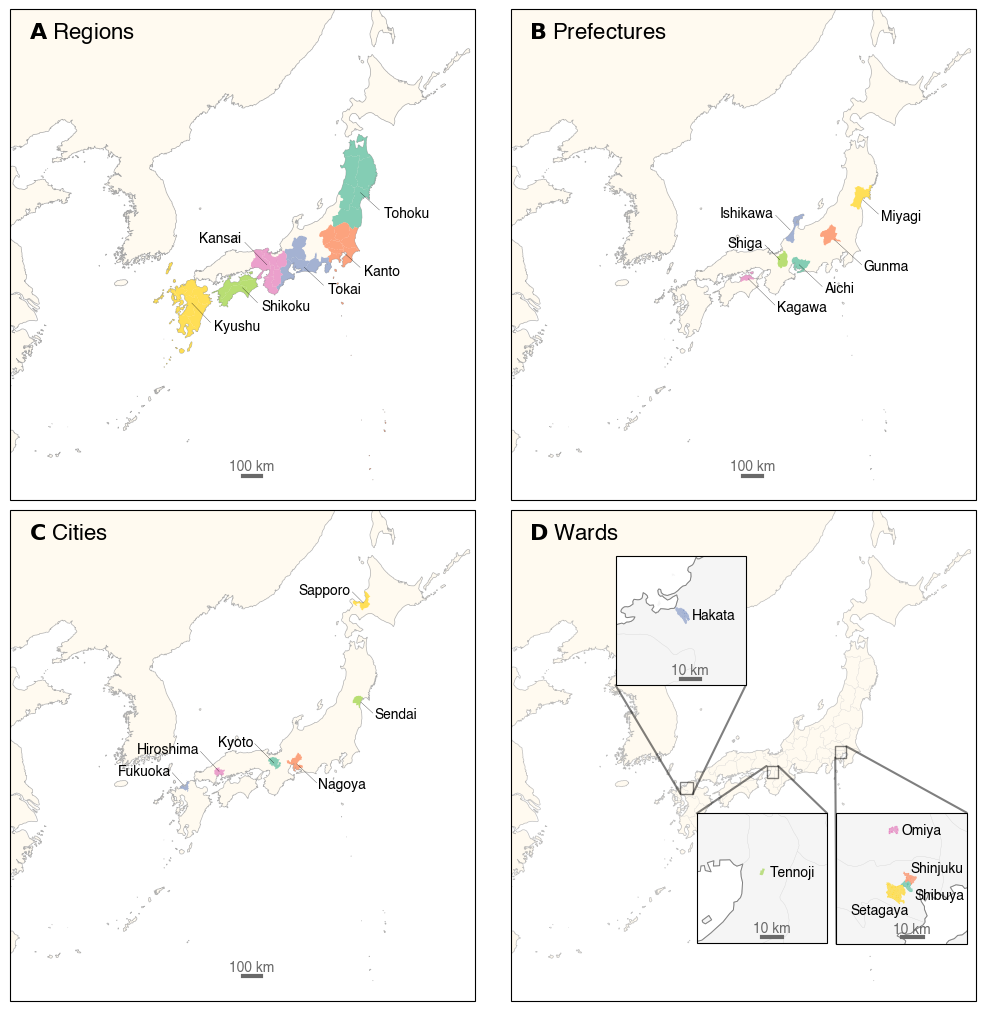

In [48]:
two_by_two = True
figsize = (10, 10) if two_by_two else (10, 3.33)
subplot_nrows_ncols = (2, 2) if two_by_two else (1, 4)

fig = plt.figure(figsize=figsize, layout='constrained')
cmap = plt.get_cmap('Set2')
toponym_fontsize = MEDIUM_FONT_SIZE # if two_by_two else SMALL_FONT_SIZE
panel_title_fontsize = PANEL_LABEL_SIZE if two_by_two else LARGE_FONT_SIZE
panel_title_loc = (0.04, 0.94) if two_by_two else (0.04, 0.92)
scale_bar_loc = (0.5, 0.05)
inset_scale_bar_loc = (0.5, 0.05)
map_kwargs = dict(color='darkgrey', resolution='10m', lw=0.5)
district_inset_kwargs = dict(resolution='10m', color='dimgrey', lw=0.7, alpha=1)
main_pref_kwargs = dict(lw=0.06, facecolor='none', edgecolor='lightgrey', alpha=0.6)
inset_pref_kwargs = dict(lw=0.15, facecolor='none', edgecolor='lightgrey', alpha=0.9)
scale_bar_kwargs = dict(color='dimgrey', text_kwargs={'size': toponym_fontsize})
arrow_kwargs = dict(color='black', linewidth=0.2)

# text_offset = {'京都': (-1, 0.5), '名古屋': (0.5, -0.2), '福岡': (0.2, -0.3),
#                '広島': (0.2, -0.3), '仙台': (0.2, -0.3), '札幌': (0.3, -0.2), 
#                '愛知': (0.7, -0.6), '群馬': (0.4, 0), '石川': (-3, 0.4), 
#                '香川': (-0.2, -0.7), '滋賀': (-1.8, 0.4), '宮城': (0.3, -0.4), 
#                '渋谷': (0.02, -0.02), '新宿': (-0.2, 0.04), '博多': (0.02, 0.02), 
#                '大宮': (0.02, 0), '天王寺': (0.02, 0.02), '世田谷': (-0.22, -0.1)}

text_offset = {
    '東北': 1.4, '関東': 1.2, '東海': 1.4, '関西': -1.6, '四国': 1.2, '九州': 1.4,
    '愛知': 1.4, '群馬': 1.6, '石川': -1, '香川': 1.6, '滋賀': -1, '宮城': 1, 
    '京都': -1.2, '名古屋': 1.2, '福岡': -0.8, '広島': -1.2, '仙台': 0.8, '札幌': -0.8, 
    '渋谷': (0.04, -0.04), '新宿': (0, 0.04), '博多': (0.06, 0), 
    '大宮': (0.04, 0), '天王寺': (0.04, 0), '世田谷': (-0.24, -0.08)}
text_arrow_vec = np.array((1.2, -0.9))

ax = fig.add_subplot(*subplot_nrows_ncols, 1, projection=lambert_area_proj)
map_data = mapviz.MapVisualizer(fig, ax=ax, extent=extent, **map_kwargs)
colors = [cmap(i) for i in range(len(region_names))]
for i, (region_name_jp, region_name_en) in enumerate(region_names):
    shape_feature = cfeature.ShapelyFeature(region_shape_dict[region_name_jp], ccrs.PlateCarree(),
                                   linewidth=0.01, facecolor=colors[i], edgecolor=colors[i], alpha=0.8)
    map_data.ax.add_feature(shape_feature)
    offset_len = text_offset[region_name_jp]
    offset = offset_len * text_arrow_vec
    text_ha = 'left' if offset_len > 0 else 'right'
    arrow_offset = 0.2 * ((offset_len > 0) * 2 - 1) * text_arrow_vec
    map_data.ax.text(region_coords[region_name_jp][1]+offset[0], 
                     region_coords[region_name_jp][0]+offset[1], 
                     region_name_en, transform=ccrs.PlateCarree(), 
                     fontsize=toponym_fontsize, color='black', ha=text_ha, va='center')
    lc = LineCollection([[
        (region_coords[region_name_jp][1]+offset[0]-arrow_offset[0], 
         region_coords[region_name_jp][0]+offset[1]-arrow_offset[1]), 
        (region_coords[region_name_jp][1]+arrow_offset[0], 
         region_coords[region_name_jp][0]+arrow_offset[1])]], 
        transform=ccrs.PlateCarree(), **arrow_kwargs)
    map_data.ax.add_collection(lc)
# map_data.ax.legend([plt.Rectangle((0,0),1,1,fc=colors[i]) for i in range(len(region_names))], 
#                    [name_en for _, name_en in region_names], loc='upper left', bbox_to_anchor=(0.03, 0.91), 
#                     fontsize=toponym_fontsize)
mapviz.scale_bar(ax=map_data.ax, location=scale_bar_loc, length=100, **scale_bar_kwargs)
ax.text(*panel_title_loc, r'$\bf{A}$ ' + 'Regions', transform=ax.transAxes, fontsize=panel_title_fontsize, color='black')
ax.add_feature(cfeature.LAND, facecolor='floralwhite')
ax.set_frame_on(True)

ax = fig.add_subplot(*subplot_nrows_ncols, 2, projection=lambert_area_proj)
map_data = mapviz.MapVisualizer(fig, ax=ax, extent=extent, alpha=0.9, **map_kwargs)
colors = [cmap(i) for i in range(len(pref_names))]
for i, (pref_name_jp, pref_name_en) in enumerate(pref_names):
    shape_feature = cfeature.ShapelyFeature(pref_shape_dict[pref_name_en], ccrs.PlateCarree(),
                                   linewidth=0.2, facecolor=colors[i], edgecolor='none', alpha=0.8)
    map_data.ax.add_feature(shape_feature)
    offset_len = text_offset[pref_name_jp]
    offset = offset_len * text_arrow_vec
    text_ha = 'left' if offset_len > 0 else 'right'
    arrow_offset = 0.1 * ((offset_len > 0) * 2 - 1) * text_arrow_vec
    map_data.ax.text(pref_coords[pref_name_jp][1]+offset[0], 
                     pref_coords[pref_name_jp][0]+offset[1], 
                     pref_name_en, transform=ccrs.PlateCarree(), 
                     fontsize=toponym_fontsize, color='black', ha=text_ha, va='center')
    lc = LineCollection([[(pref_coords[pref_name_jp][1]+offset[0]-arrow_offset[0], 
                           pref_coords[pref_name_jp][0]+offset[1]-arrow_offset[1]),
                          (pref_coords[pref_name_jp][1]+arrow_offset[0],
                           pref_coords[pref_name_jp][0]+arrow_offset[1])]], 
                          transform=ccrs.PlateCarree(), **arrow_kwargs)
    map_data.ax.add_collection(lc)
    # map_data.ax.axline((pref_coords[pref_name_jp][1]+offset[0]*0.8, pref_coords[pref_name_jp][0]+offset[1]*0.8),
    #                    (pref_coords[pref_name_jp][1]+offset[0]*0.2, pref_coords[pref_name_jp][0]+offset[1]*0.2), 
    #                    transform=ccrs.PlateCarree(), color='black', linewidth=0.5)
mapviz.scale_bar(ax=map_data.ax, location=scale_bar_loc, length=100, **scale_bar_kwargs)
ax.text(*panel_title_loc, r'$\bf{B}$ ' + 'Prefectures', transform=ax.transAxes, fontsize=panel_title_fontsize, color='black')
ax.add_feature(cfeature.LAND, facecolor='floralwhite')
ax.set_frame_on(True)

ax = fig.add_subplot(*subplot_nrows_ncols, 3, projection=lambert_area_proj)
map_data = mapviz.MapVisualizer(fig, ax=ax, extent=extent, alpha=0.9, **map_kwargs)
colors = [cmap(i) for i in range(len(city_names))]
for i, (city_name_jp, city_name_en) in enumerate(city_names):
    shape_feature = cfeature.ShapelyFeature(city_shape_dict[city_name_jp], ccrs.PlateCarree(),
                                   linewidth=0.2, facecolor=colors[i], edgecolor='none', alpha=0.8)
    map_data.ax.add_feature(shape_feature)
    offset_len = text_offset[city_name_jp]
    offset = offset_len * text_arrow_vec
    text_ha = 'left' if offset_len > 0 else 'right'
    arrow_offset = 0.08 * ((offset_len > 0) * 2 - 1) * text_arrow_vec
    map_data.ax.text(city_coords[city_name_jp][1]+offset[0],
                     city_coords[city_name_jp][0]+offset[1],
                     city_name_en, transform=ccrs.PlateCarree(), 
                     fontsize=toponym_fontsize, color='black', ha=text_ha, va='center')
    lc = LineCollection([[(city_coords[city_name_jp][1]+offset[0]-arrow_offset[0], 
                           city_coords[city_name_jp][0]+offset[1]-arrow_offset[1]),
                          (city_coords[city_name_jp][1]+arrow_offset[0],
                           city_coords[city_name_jp][0]+arrow_offset[1])]], 
                          transform=ccrs.PlateCarree(), **arrow_kwargs)
    map_data.ax.add_collection(lc)
mapviz.scale_bar(ax=map_data.ax, location=scale_bar_loc, length=100, **scale_bar_kwargs)
ax.text(*panel_title_loc, r'$\bf{C}$ ' + 'Cities', transform=ax.transAxes, fontsize=panel_title_fontsize, color='black')
ax.add_feature(cfeature.LAND, facecolor='floralwhite')
ax.set_frame_on(True)

ax = fig.add_subplot(*subplot_nrows_ncols, 4, projection=lambert_area_proj)
map_data = mapviz.MapVisualizer(fig, ax=ax, extent=extent, alpha=0.75, **map_kwargs)
ax.add_feature(cfeature.LAND, facecolor='floralwhite')
for pref_name_en, pref_geom in pref_shape_dict.items():
    shape_feature = cfeature.ShapelyFeature(pref_geom, ccrs.PlateCarree(), **inset_pref_kwargs)
    map_data.ax.add_feature(shape_feature)

colors = [cmap(i) for i in range(len(district_names))]

inset_indices = [[0, 1, 3, 5], [2], [4]]
inset_coords = [(0.7, 0.1, 0.28, 0.3), (0.225, 0.625, 0.28, 0.3), (0.4, 0.1, 0.28, 0.3)]
for inset_index, inset_coord in zip(inset_indices, inset_coords):
    inset_ax = map_data.ax.inset_axes(inset_coord, projection=lambert_area_proj)
    inset_ax.add_feature(cfeature.LAND, facecolor='whitesmoke')
    inset_ax.set_frame_on(True)
    inset_extent = (np.mean([district_coords[district_names[i][0]][1] for i in inset_index])-0.34,
                    np.mean([district_coords[district_names[i][0]][1] for i in inset_index])+0.34,
                    np.mean([district_coords[district_names[i][0]][0] for i in inset_index])-0.31,
                    np.mean([district_coords[district_names[i][0]][0] for i in inset_index])+0.25)
    inset_data = mapviz.MapVisualizer(fig, extent=inset_extent, projection=lambert_area_proj, ax=inset_ax, 
                                     **district_inset_kwargs)
    for pref_name_en, pref_geom in pref_shape_dict.items():
        shape_feature = cfeature.ShapelyFeature(pref_geom, ccrs.PlateCarree(), **inset_pref_kwargs)
        inset_data.ax.add_feature(shape_feature)
    for i, (district_name_jp, district_name_en) in zip(inset_index, [district_names[i] for i in inset_index]):
        shape_feature = cfeature.ShapelyFeature(district_shape_dict[district_name_en], ccrs.PlateCarree(),
                                   linewidth=0, facecolor=colors[i], edgecolor='none', alpha=1)
        inset_data.ax.add_feature(shape_feature)
        inset_data.ax.text(district_coords[district_name_jp][1]+text_offset[district_name_jp][0], 
                           district_coords[district_name_jp][0]+text_offset[district_name_jp][1],
                           district_name_en, transform=ccrs.PlateCarree(), 
                           fontsize=toponym_fontsize, color='black', va='center')
    mapviz.scale_bar(ax=inset_data.ax, location=scale_bar_loc, length=10, text_offset=0.01, 
                     **scale_bar_kwargs)
    for axis in ['top', 'bottom', 'left', 'right']:
        inset_ax.spines[axis].set_linewidth(3)
        inset_ax.spines[axis].set_color('red')
    rect, lines = map_data.ax.indicate_inset_zoom(inset_ax, edgecolor='black')
    # rect.set(lw=10)
    for line in lines:
        line.set(lw=1.5)
ax.text(*panel_title_loc, r'$\bf{D}$ ' + 'Wards', transform=ax.transAxes, fontsize=panel_title_fontsize, color='black')
ax.set_frame_on(True)

In [49]:
fig.savefig(os.path.join(figdir, 'repr_toponyms_on_map_2x2.pdf'), bbox_inches='tight')

In [53]:
file_names_list = {toponym: qfdict[toponym]
                   for toponym, _ in region_names + pref_names + city_names + district_names}
file_names_list.update({noun: qfdict_commonnoun[noun] 
                        for noun, _ in common_nouns_nonspatial + common_nouns_spatial})
file_names_list.update({toponym: qfdict_abroad[toponym] for toponym, _ in abroad_names})
file_names_list['all'] = all_file


In [55]:
with open('../scratch/file_names_list.json', 'w', encoding='utf-8') as f:
    json.dump(file_names_list, f, ensure_ascii=False, indent=4)

In [52]:
all_file

'mesh3_20201203185223_tweetcountall_ver201809_v2.csv'

In [58]:
path_to_sig_dir

'/Users/hiraokt1/Dropbox/research/projects/geotagged_tweets/scratch/significance'

In [56]:
import shutil
from pathlib import Path


In [62]:
for toponym, _ in region_names + pref_names + city_names + district_names:
    file_name = file_names_list[toponym]
    shutil.copy2(Path(path_to_sig_dir) / Path(file_name),
                    Path('../original') / 'selected_files')

for noun, _ in common_nouns_nonspatial + common_nouns_spatial:
    file_name = file_names_list[noun]
    shutil.copy2(Path(path_to_preprocessed_dir) / Path(file_name),
                    Path('../original') / 'selected_files')
        
for toponym, _ in abroad_names:
    file_name = file_names_list[toponym]
    shutil.copy2(Path(path_to_preprocessed_dir) / Path(file_name),
                    Path('../original') / 'selected_files')

file_name = file_names_list['all']
shutil.copy2(Path(path_to_sig_dir) / Path(file_name),
                Path('../original') / 'selected_files')

'../original/selected_files/mesh3_20201203185223_tweetcountall_ver201809_v2.csv'

In [32]:
all_keyword_df = all_df.rename(columns={'tweetcount': 'tweetcount_all'})
for names in [region_names, pref_names, city_names, district_names]:
    for toponym, toponym_en in names:
        target_df = analysis.read_sig_file(path_to_sig_dir, qfdict[toponym])
        all_keyword_df = pd.merge(all_keyword_df, target_df[['m3code', 'tweetcount']], on='m3code', how='left')\
            .fillna(0).rename(columns={'tweetcount': 'tweetcount_' + toponym_en})
for noun_jp, noun_en in common_nouns_nonspatial + common_nouns_spatial:
    target_df = pd.read_csv(os.path.join(path_to_preprocessed_dir, qfdict_commonnoun[noun_jp]), index_col=0, dtype={'m3code':str})
    print('The columns \"m3code\" are unique:', target_df['m3code'].is_unique)
    all_keyword_df = pd.merge(all_keyword_df, target_df[['m3code', 'tweetcount']], on='m3code', how='left')\
        .fillna(0).rename(columns={'tweetcount': 'tweetcount_' + noun_en})
for noun_jp, noun_en in abroad_names:
    target_df = pd.read_csv(os.path.join(path_to_preprocessed_dir, qfdict_abroad[noun_jp]), index_col=0, dtype={'m3code':str})
    print('The columns \"m3code\" are unique:', target_df['m3code'].is_unique)
    all_keyword_df = pd.merge(all_keyword_df, target_df[['m3code', 'tweetcount']], on='m3code', how='left')\
        .fillna(0).rename(columns={'tweetcount': 'tweetcount_' + noun_en})

The columns "m3code" are unique: True
The columns "m3code" are unique: True
The columns "m3code" are unique: True
The columns "m3code" are unique: True
The columns "m3code" are unique: True
The columns "m3code" are unique: True
The columns "m3code" are unique: True
The columns "m3code" are unique: True
The columns "m3code" are unique: True
The columns "m3code" are unique: True
The columns "m3code" are unique: True
The columns "m3code" are unique: True
The columns "m3code" are unique: True
The columns "m3code" are unique: True
The columns "m3code" are unique: True
The columns "m3code" are unique: True
The columns "m3code" are unique: True
The columns "m3code" are unique: True
The columns "m3code" are unique: True
The columns "m3code" are unique: True
The columns "m3code" are unique: True
The columns "m3code" are unique: True
The columns "m3code" are unique: True
The columns "m3code" are unique: True
The columns "m3code" are unique: True
The columns "m3code" are unique: True
The columns 

In [35]:
all_keyword_df

m3code  tweetcount_all      area    density   latitude  longitude  \
0       30275333               1  1.203418   0.830966  20.445833  127.41875   
1       30346262               9  1.202588   7.483861  20.554167  134.28125   
2       30365005               1  1.203609   0.830835  20.420833  136.06875   
3       30365015              81  1.203545  67.301158  20.429167  136.06875   
4       30365016              11  1.203545   9.139663  20.429167  136.08125   
...          ...             ...       ...        ...        ...        ...   
299209  68482711               1  0.904724   1.105310  45.512500  148.89375   
299210  68482721               1  0.904591   1.105472  45.520833  148.89375   
299211  68496778               2  0.898623   2.225628  45.895833  149.98125   
299212  68497717               1  0.898090   1.113474  45.929167  149.96875   
299213  68533375               2  0.902606   2.215806  45.645833  153.44375   

        tweetcount_Tohoku  tweetcount_Kanto  tweetcount_Tokai  \
0                     0.0               0.0               0.0   
1                     0.0               0.0               0.0   
2                     0.0               0.0               0.0   
3                     0.0               0.0               0.0   
4                     0.0               0.0               0.0   
...                   ...               ...               ...   
299209                0.0               0.0               0.0   
299210                0.0               0.0               0.0   
299211                0.0               0.0               0.0   
299212                0.0               0.0               0.0   
299213                0.0               0.0               0.0   

        tweetcount_Kansai  ...  tweetcount_university  tweetcount_hotel  \
0                     0.0  ...                    0.0               0.0   
1                     0.0  ...                    0.0               0.0   
2                     0.0  ...                    0.0               0.0   
3                     0.0  ...                    0.0               0.0   
4                     0.0  ...                    1.0               0.0   
...                   ...  ...                    ...               ...   
299209                0.0  ...                    0.0               0.0   
299210                0.0  ...                    0.0               0.0   
299211                0.0  ...                    0.0               0.0   
299212                0.0  ...                    0.0               0.0   
299213                0.0  ...                    0.0               0.0   

        tweetcount_airport  tweetcount_shrine  tweetcount_Hawaii  \
0                      0.0                0.0                0.0   
1                      0.0                0.0                0.0   
2                      0.0                0.0                0.0   
3                      0.0                0.0                0.0   
4                      0.0                0.0                0.0   
...                    ...                ...                ...   
299209                 0.0                0.0                0.0   
299210                 0.0                0.0                0.0   
299211                 0.0                0.0                0.0   
299212                 0.0                0.0                0.0   
299213                 0.0                0.0                0.0   

        tweetcount_Dubai  tweetcount_Hong Kong  tweetcount_New York  \
0                    0.0                   0.0                  0.0   
1                    0.0                   0.0                  0.0   
2                    0.0                   0.0                  0.0   
3                    0.0                   0.0                  0.0   
4                    0.0                   0.0                  0.0   
...                  ...                   ...                  ...   
299209               0.0                   0.0                  0

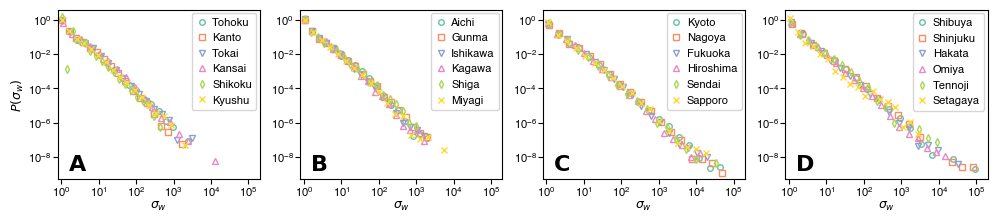

In [96]:
fig, axes = plt.subplots(1, 4, figsize=(12, 2.2))
toponym_colors = plt.colormaps['Set2'](np.arange(6))
toponym_symbols = ['o', 's', 'v', '^', 'd', 'x']
for i, names in enumerate(list_of_toponyms):
    ax = axes[i]
    for j, (toponym_jp, toponym_en) in enumerate(names):
        densities = all_keyword_df['tweetcount_'+toponym_en].to_numpy() / all_keyword_df['area'].to_numpy()
        analysis.plot_single_histogram(
            ax, densities, numbins=18, xscale='log', yscale='log', discrete=False, 
            marker=toponym_symbols[j], ms=4, ls='', color=toponym_colors[j], mfc='none', mew=1, label=toponym_en)
    ax.minorticks_off()
    ax.tick_params(axis='both', which='major', labelsize=SMALL_FONT_SIZE, pad=1)
    ax.set_xlabel(r'$\sigma_w$', labelpad=0.5)
    if i == 0:
        ax.set_ylabel(r'$P(\sigma_w)$', labelpad=1.5)
    ax.legend(loc='upper right', fontsize=SMALL_FONT_SIZE,
              handlelength=0.9, handletextpad=0.5, borderaxespad=0.3)
    ax.set_xlim(left=0.8, right=2e5)
    ax.set_ylim(bottom=5e-10, top=4)
    ax.text(0.05, 0.05, r'$\bf{'+chr(65+i)+'}$', transform=ax.transAxes, fontsize=PANEL_LABEL_SIZE, 
            font=PANEL_LABEL_FONT, color='black')

In [97]:
fig.savefig(os.path.join(figdir, 'density_pdf_all_toponyms.pdf'), dpi=300, bbox_inches='tight')

# Scatter plots

In [25]:
def plot_all_vs_keyword(ax, data_all, data_word, 
                        style='scatter', cmap='Blues', linecolor='#482475'):
    nonzero = data_word > 0
    data_all_nz = data_all[nonzero]
    data_word_nz = data_word[nonzero]
    if style == 'scatter':
        ax.scatter(data_all_nz, data_word_nz, s=1, c='k', marker='o', edgecolors='none', 
                    alpha=0.2, rasterized=True)
    elif style == 'contour':
        xmesh, ymesh, zmesh, dlevels = \
            models.data_contours(data_all_nz, data_word_nz, log_scale=True)
        nlevels = len(dlevels) + 1
        fillcolors = plt.colormaps[cmap]
        ax.contourf(xmesh, ymesh, zmesh, 
            levels=np.append(dlevels, np.max(zmesh)), 
            colors=[fillcolors((i+1)/nlevels) for i in range(nlevels)], alpha=0.5)
        ax.contour(xmesh, ymesh, zmesh, 
                levels=np.append(dlevels, np.max(zmesh)), 
                colors=linecolor, alpha=0.5, linewidths=0.6)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(left=1, right=1E6)
    ax.set_ylim(bottom=0.8, top=5E4)

In [26]:
def scatter_plot_all_vs_keyword_empirical(ax, all_kw_df, kw_en):
    data_all = all_kw_df['tweetcount_all'].to_numpy()
    data_word = all_kw_df['tweetcount_' + kw_en].to_numpy()
    plot_all_vs_keyword(ax, data_all, data_word, style='scatter')
    ax.minorticks_off()

In [27]:
def contour_plot_all_vs_keyword_binomial(ax, all_kw_df, kw_en, rng, return_model=False, **params):
    data_all = all_kw_df['tweetcount_all'].to_numpy()
    data_word = all_kw_df['tweetcount_' + kw_en].to_numpy()
    plot_all_vs_keyword(ax, data_all, data_word, 
                        style='contour', cmap='Blues', linecolor='#482475')
    p_binomial = params['p_binomial']
    model_all, model_word = \
        models.random_data_from_model(data_all, p_binomial[kw_en], rng, num_repeat=5)
    plot_all_vs_keyword(ax, model_all, model_word, 
                        style='contour', cmap='Reds', linecolor='#D63230')
    ax.minorticks_off()

In [28]:
def contour_plot_all_vs_keyword_coreperi(ax, all_kw_df, kw_en, rng, return_model=False, **params):
    data_all = all_kw_df['tweetcount_all'].to_numpy()
    data_word = all_kw_df['tweetcount_' + kw_en].to_numpy()
    plot_all_vs_keyword(ax, data_all, data_word, 
                        style='contour', cmap='Blues', linecolor='#482475')
    distance = analysis.distance_from_center(all_kw_df, keyword=kw_en)
    near_p, radius, exponent = params['near_p'], params['radius'], params['exponent']
    p = models.core_periphery_model(distance, near_p[kw_en], radius[kw_en], exponent[kw_en])
    model_all, model_word = \
        models.random_data_from_model(data_all, p, rng, num_repeat=5)
    plot_all_vs_keyword(ax, model_all, model_word, 
                        style='contour', cmap='Reds', linecolor='#D63230')
    ax.minorticks_off()

In [29]:
def plot_all_vs_many_keywords(axes, all_kw_df, list_of_keywords, 
                              model='none', rng=None, with_jp=True, **params):
    for i, keywords in enumerate(list_of_keywords):
        for j, (keyword_jp, keyword_en) in enumerate(keywords):
            print('Processing:', keyword_en)
            if axes.ndim == 1:
                ax = axes[j]
            else:
                ax = axes[i, j]
            if model == 'none':
                scatter_plot_all_vs_keyword_empirical(ax, all_kw_df, keyword_en)
            elif model == 'binomial':
                contour_plot_all_vs_keyword_binomial(ax, all_kw_df, keyword_en, rng, **params)
            elif model == 'coreperi':
                contour_plot_all_vs_keyword_coreperi(ax, all_kw_df, keyword_en, rng, **params)
            ax.text(0.07, 0.95, keyword_en, ha='left', va='top', 
                    transform=ax.transAxes, fontsize=LARGE_FONT_SIZE)
            if with_jp:
                ax.text(0.07, 0.83, unicodedata.normalize('NFKC', keyword_jp), ha='left', va='top', 
                        transform=ax.transAxes, fontsize=MEDIUM_FONT_SIZE)
            
            if axes.ndim == 1 or i == len(axes) - 1:
                ax.set_xlabel('$n_\mathrm{all}$', labelpad=1)
            else:
                ax.set_xticklabels([])
            if j == 0:
                ax.set_ylabel('$n_w$', labelpad=1)
            else:
                ax.set_yticklabels([])
    return axes

In [30]:
def plot_all_vs_many_keywords2(fig, all_kw_df, dict_of_keywords, 
                               model='none', rng=None, with_jp=True, **params):
    subfigs = fig.subfigures(len(dict_of_keywords), 1, hspace=0.07, wspace=0)
    axes = []
    for i, (category, keywords) in enumerate(dict_of_keywords.items()):
        subfig = subfigs[i]
        subfig.text(-0.015, 0.5, category, ha='center', va='center', fontsize=LARGE_FONT_SIZE, rotation=90)
        axes.append(subfig.subplots(1, len(keywords)))
        for j, (keyword_jp, keyword_en) in enumerate(keywords):
            print('Processing', keyword_en)
            ax = axes[i][j]
            if model == 'none':
                scatter_plot_all_vs_keyword_empirical(ax, all_kw_df, keyword_en)
            elif model == 'binomial':
                contour_plot_all_vs_keyword_binomial(ax, all_kw_df, keyword_en, rng, **params)
            elif model == 'coreperi':
                contour_plot_all_vs_keyword_coreperi(ax, all_kw_df, keyword_en, rng, **params)
            ax.text(0.07, 0.95, keyword_en, ha='left', va='top', 
                    transform=ax.transAxes, fontsize=LARGE_FONT_SIZE)
            if with_jp:
                ax.text(0.07, 0.83, unicodedata.normalize('NFKC', keyword_jp), ha='left', va='top', 
                        transform=ax.transAxes, fontsize=MEDIUM_FONT_SIZE)
            ax.tick_params(axis='both', which='major', labelsize=SMALL_FONT_SIZE, pad=0.5)
            ax.set_xlabel('$n_\mathrm{all}$', labelpad=-0.4)
            if j == 0:
                ax.set_ylabel('$n_w$', labelpad=0.8)
            else:
                ax.set_yticklabels([])
    return subfigs, axes

In [31]:
dict_of_keywords = {'Regions': region_names, 'Prefectures': pref_names, 
                    'Cities': city_names, 'Wards': district_names, 
                    'Common nouns 1': common_nouns_nonspatial,
                    'Common nouns 2': common_nouns_spatial,
                    'Foreign places': abroad_names}
keywords_en = [kw for kws in dict_of_keywords.values() for _, kw in kws]

Processing Tohoku
Processing Kanto
Processing Tokai
Processing Kansai
Processing Shikoku
Processing Kyushu
Processing Aichi
Processing Gunma
Processing Ishikawa
Processing Kagawa
Processing Shiga
Processing Miyagi
Processing Kyoto
Processing Nagoya
Processing Fukuoka
Processing Hiroshima
Processing Sendai
Processing Sapporo
Processing Shibuya
Processing Shinjuku
Processing Hakata
Processing Omiya
Processing Tennoji
Processing Setagaya
Processing telephone
Processing music
Processing vegetable
Processing society
Processing wallet
Processing reason
Processing trip
Processing park
Processing university
Processing hotel
Processing airport
Processing shrine
Processing Hawaii
Processing Dubai
Processing Hong Kong
Processing New York
Processing Singapore
Processing Seoul


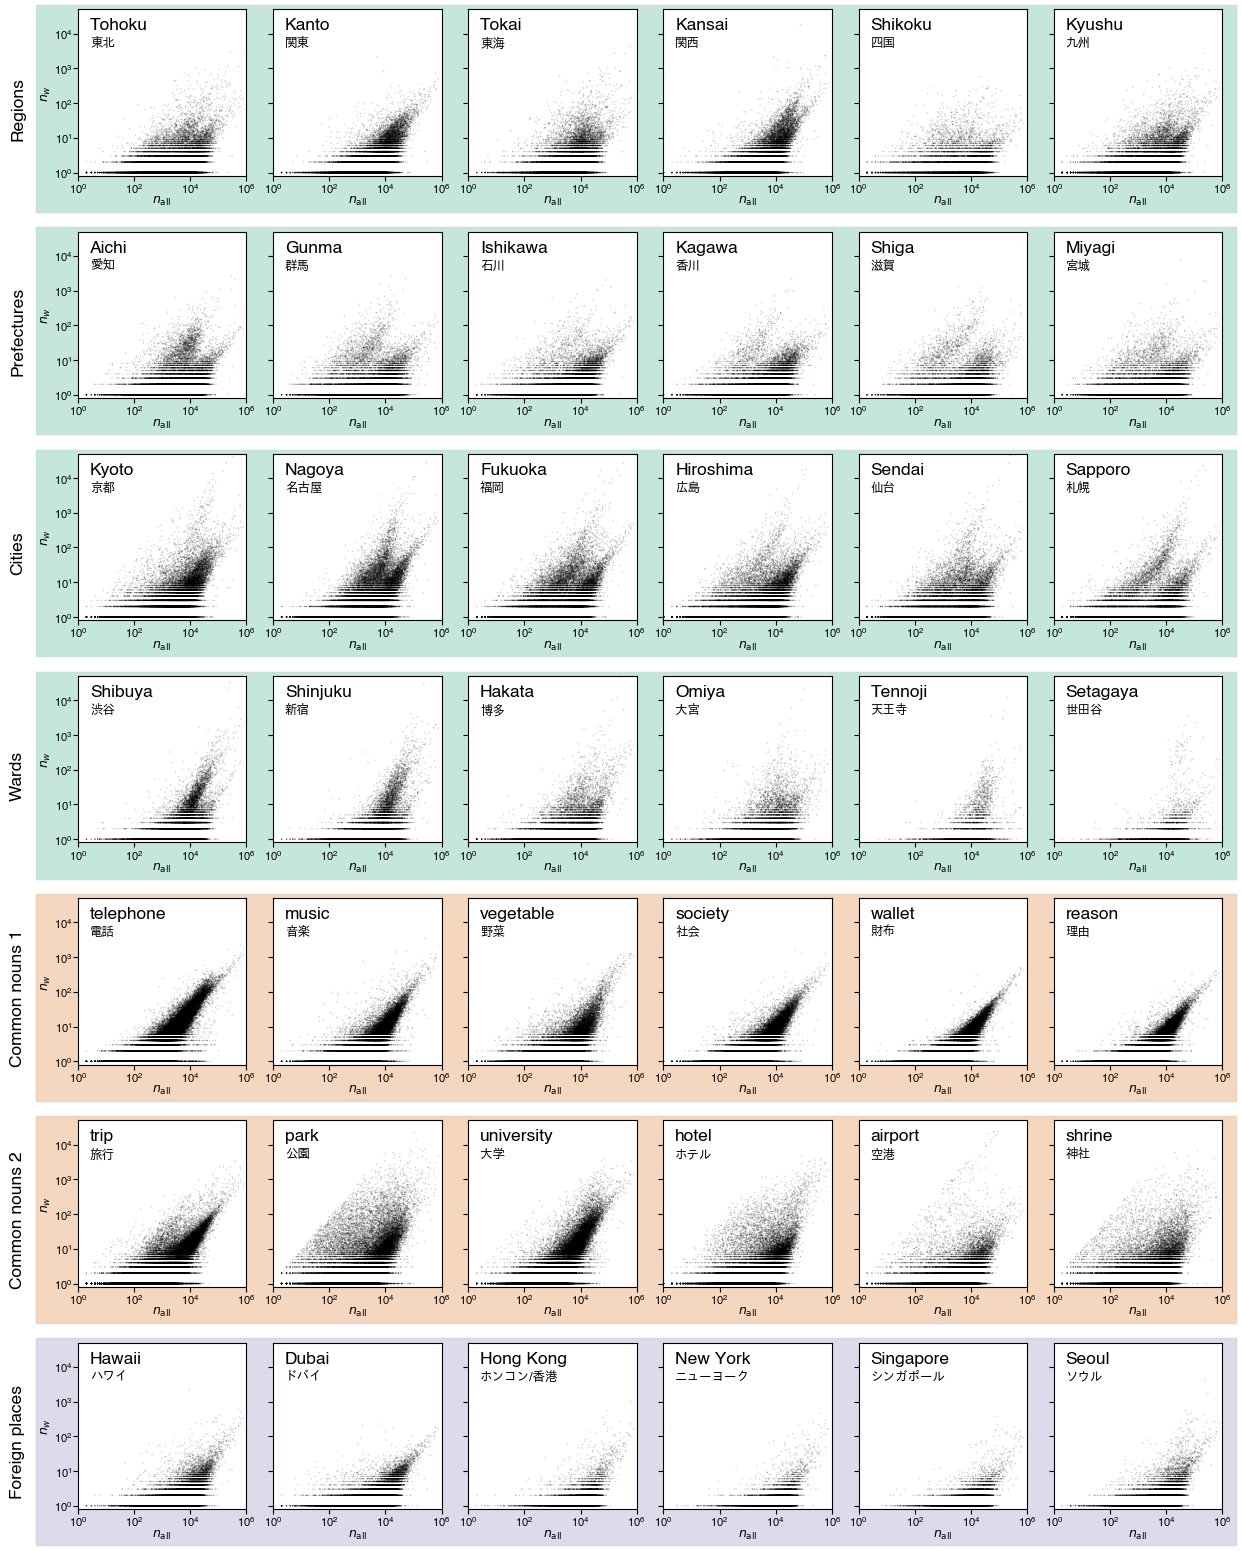

In [ ]:
nrows = len(dict_of_keywords)
fig = plt.figure(figsize=(12, 2.2*nrows), layout='constrained')
subfigs, axes = plot_all_vs_many_keywords2(fig, all_keyword_df, dict_of_keywords, 
                                           model='none', with_jp=True)

bgcolors = plt.colormaps['Dark2'](np.array([0] * 4 + [1] * 2 + [2]))
for subfig, bgcolor in zip(subfigs, bgcolors):
    subfig.patch.set(facecolor=bgcolor, edgecolor='lightgrey', linewidth=1, alpha=0.25)

In [ ]:
# fig.savefig(os.path.join(figdir, 'all_tweets_vs_toponym_subsample_many.pdf'), bbox_inches='tight')

# Models

In [37]:
rng = np.random.default_rng()

In [32]:
p_binomial = {}
aic_binomial = {}
bic_binomial = {}
for keyword_en in (kw for kws in dict_of_keywords.values() for _, kw in kws):
    data_all = all_keyword_df['tweetcount_all'].to_numpy()
    data_word = all_keyword_df['tweetcount_' + keyword_en].to_numpy()
    p, aic, bic = models.binomial_mle(data_word, data_all)
    p_binomial[keyword_en] = p
    aic_binomial[keyword_en] = aic
    bic_binomial[keyword_en] = bic

Processing Tohoku
Processing Kanto
Processing Tokai
Processing Kansai
Processing Shikoku
Processing Kyushu
Processing Aichi
Processing Gunma
Processing Ishikawa
Processing Kagawa
Processing Shiga
Processing Miyagi
Processing Kyoto
Processing Nagoya
Processing Fukuoka
Processing Hiroshima
Processing Sendai
Processing Sapporo
Processing Shibuya
Processing Shinjuku
Processing Hakata
Processing Omiya
Processing Tennoji
Processing Setagaya
Processing telephone
Processing music
Processing vegetable
Processing society
Processing wallet
Processing reason
Processing trip
Processing park
Processing university
Processing hotel
Processing airport
Processing shrine
Processing Hawaii
Processing Dubai
Processing Hong Kong
Processing New York
Processing Singapore
Processing Seoul


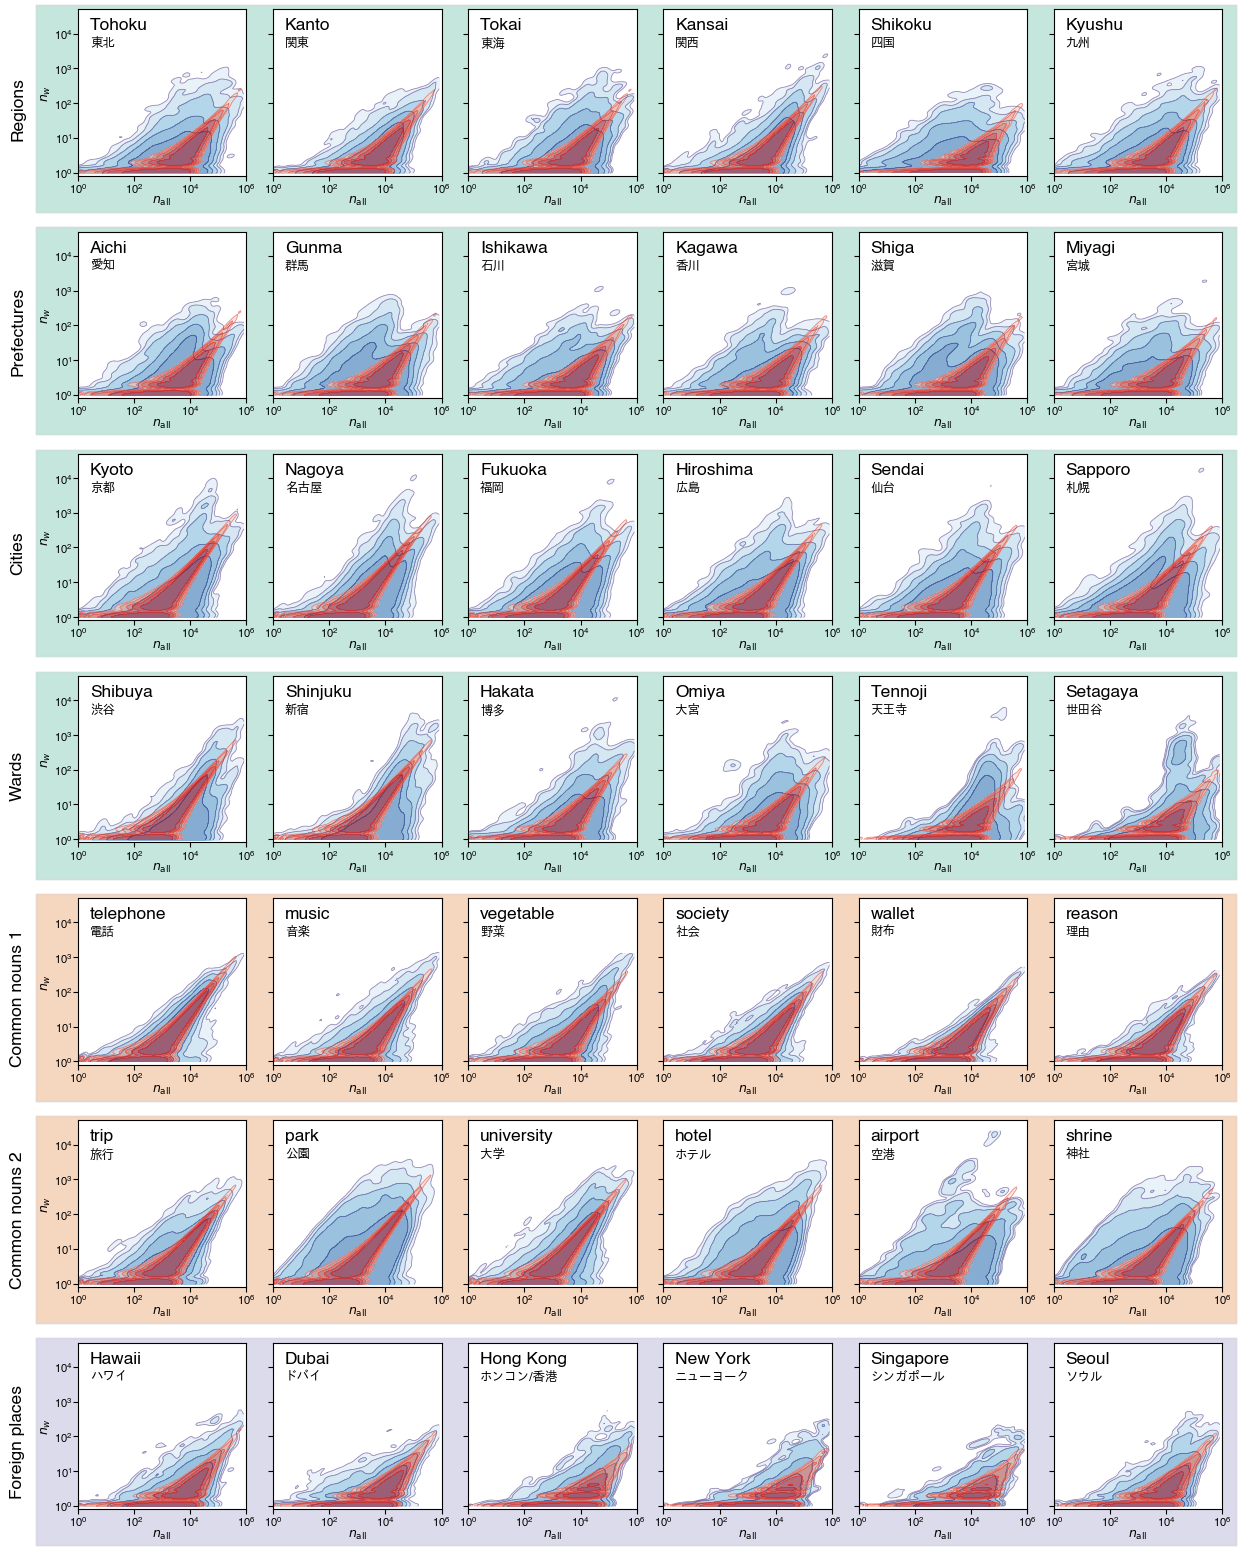

In [ ]:
nrows = len(dict_of_keywords)
fig = plt.figure(figsize=(12, 2.2*nrows), layout='constrained')
subfigs, axes = plot_all_vs_many_keywords2(fig, all_keyword_df, dict_of_keywords, 
                                           model='binomial', rng=rng, p_binomial=p_binomial)
bgcolors = plt.colormaps['Dark2'](np.array([0] * 4 + [1] * 2 + [2]))
for subfig, bgcolor in zip(subfigs, bgcolors):
    subfig.patch.set(facecolor=bgcolor, edgecolor='lightgrey', linewidth=1, alpha=0.25)

In [ ]:
fig.savefig(os.path.join(figdir, 'all_tweets_vs_toponym_subsample_many_binomial.pdf'), bbox_inches='tight')

In [ ]:
def entropy_empirical(sequence):
    counts = np.bincount(sequence)
    nonzero_counts = counts[counts > 0]
    probs = nonzero_counts / len(sequence)
    return -np.sum(probs * np.log(probs))

def entropy_binomial(sequence, n, p):
    likelihoods = scipy.stats.binom.pmf(sequence, n, p)
    likelihoods = np.where(likelihoods > 1e-20, likelihoods, 1e-20)
    return -np.sum(np.log(likelihoods)) / len(sequence)

# def KL_divergence_from_binomial(sequence, n, p):
#     return empirical_entropy_binomial(sequence, n, p) - empirical_entropy_empirical(sequence)

def KL_divergence_from_binomial(nums_word, nums_all):
    p = np.sum(nums_word) / np.sum(nums_all)
    kld = 0
    for n_all, counts in zip(*np.unique(nums_all, return_counts=True)):
        sequence = nums_word[nums_all == n_all].astype(int)
        kld += (entropy_binomial(sequence, n_all, p) - entropy_empirical(sequence)) * counts
    return kld / len(nums_all)

In [ ]:
%%script false --no-raise-error
relative_entropy = {keyword_en: [] for keyword_en in keywords_en}
relative_entropy_non_zero = {keyword_en: [] for keyword_en in keywords_en}
for keyword_en in keywords_en:
    print('Processing', keyword_en)
    all_onekw_df = all_keyword_df[['tweetcount_all', 'tweetcount_'+keyword_en]]
    all_onekw_nonzero_df = all_onekw_df[all_onekw_df['tweetcount_'+keyword_en] > 0]
    for _ in range(50):
        nsample = 20000
        sample_df = all_onekw_df.sample(n=nsample, replace=True, random_state=rng)
        kld = KL_divergence_from_binomial(sample_df['tweetcount_'+keyword_en].to_numpy(), 
                                          sample_df['tweetcount_all'].to_numpy())
        relative_entropy[keyword_en].append(kld)

        nsample_nonzero = 3000
        sample_nonzero_df = all_onekw_nonzero_df.sample(n=nsample_nonzero, replace=True, random_state=rng)
        kld_nonzero = KL_divergence_from_binomial(sample_nonzero_df['tweetcount_'+keyword_en].to_numpy(), 
                                                  sample_nonzero_df['tweetcount_all'].to_numpy())
        relative_entropy_non_zero[keyword_en].append(kld_nonzero)

In [ ]:
total_counts = {}
for category, keywords in dict_of_keywords.items():
    for keyword_jp, keyword_en in keywords:
        total_count = all_keyword_df['tweetcount_' + keyword_en].sum()
        total_counts[keyword_en] = total_count
print('Minimum total count:', min(total_counts.values()))

Minimum total count: 17137.0


In [ ]:
min_nonzero_len = 100000
for keyword_en in keywords_en:
    nonzero_len = (all_keyword_df['tweetcount_'+keyword_en] > 0).sum()
    min_nonzero_len = min(min_nonzero_len, nonzero_len)
print('Minimum number of nonzero counts:', min_nonzero_len)

Minimum number of nonzero counts: 3072


In [ ]:
%%script false --no-raise-error
labels, klds = zip(*relative_entropy.items())
mean = np.mean(np.array(klds), axis=1)
ci_low, ci_high = scipy.stats.bootstrap((np.array(klds).T, ), np.mean, 
                                        n_resamples=1000, confidence_level=0.95, 
                                        random_state=rng).confidence_interval

fig, ax = plt.subplots(figsize=(4, 10))
ys = np.arange(len(labels), 0, -1)
ax.scatter(mean, ys, s=20, zorder=5)
ax.hlines(ys, ci_low, ci_high, lw=1.5, zorder=4.9)
ax.axvline(0, color='darkgrey', lw=2, zorder=2.1)
ax.set_yticks(ys, labels=labels)
ax.grid(lw=0.5)
ax.set_ylim(0, len(labels)+1)
# ax.text(-0.1, 1, panel_labels[0][col],
#         ha='left', va='bottom', weight='bold', 
#         transform=ax.transAxes, font=PANEL_LABEL_FONT, fontsize=PANEL_LABEL_SIZE)

In [ ]:
%%script false --no-raise-error
ncols = 2
labels, klds = zip(*relative_entropy.items())
klds_nonzero = [relative_entropy_non_zero[label] for label in labels]
total_count_arr = [total_counts[label] for label in labels]
colors = plt.colormaps['Dark2'](np.array([0] * 24 + [1] * 12 + [2] * 6))
fig, axes = plt.subplots(2, ncols, figsize=(4 * ncols, 12), 
                         gridspec_kw={'height_ratios': [4.5, 1], 'wspace': 0.35, 'hspace': 0.15})
panel_labels = np.array(list(map(chr, range(ord('A'), ord('A') + 2 * ncols)))).reshape(2, ncols)
for col in range(ncols):
    if col == 0:
        mean = np.mean(np.array(klds), axis=1)
        ci_low, ci_high = scipy.stats.bootstrap((np.array(klds).T, ), np.mean, 
                                                n_resamples=1000, confidence_level=0.95, 
                                                random_state=rng).confidence_interval
        xlabel = r'$D_\mathrm{KL}(Q \parallel P)$'
        xticks = None
    # elif col == 1:
    #     mean = np.mean(np.array(klds), axis=1) / total_count_arr
    #     ci_low, ci_high = scipy.stats.bootstrap((np.array(klds).T / total_count_arr, ), np.mean,
    #                                             n_resamples=1000, confidence_level=0.95,
    #                                             random_state=rng).confidence_interval
    #     xlabel = r'$D_\mathrm{KL}(p_\mathrm{data}||p_\mathrm{model})/N_w$'
    else:
        mean = np.mean(np.array(klds_nonzero), axis=1)
        ci_low, ci_high = scipy.stats.bootstrap((np.array(klds_nonzero).T, ), np.mean,
                                                n_resamples=1000, confidence_level=0.95,
                                                random_state=rng).confidence_interval
        xlabel = r'$D_\mathrm{KL}(\tilde{Q} \parallel P)$'
        xticks = np.arange(0, np.max(ci_high)*1.05, 4)
    ax = axes[0, col]
    ys = np.arange(len(labels), 0, -1)
    ax.scatter(mean, ys, color=colors, s=20, zorder=5)
    ax.hlines(ys, ci_low, ci_high, color=colors, lw=1.5, zorder=4.9)
    ax.axvline(0, color='darkgrey', lw=2, zorder=2.1)
    ax.set_yticks(ys, labels=labels)
    ax.grid(lw=0.5)
    ax.set_ylim(0, len(labels)+1)
    ax.set_xlabel(xlabel, labelpad=1)
    ax.text(-0.1, 1, panel_labels[0][col],
            ha='left', va='bottom', weight='bold', 
            transform=ax.transAxes, font=PANEL_LABEL_FONT, fontsize=PANEL_LABEL_SIZE)
    if col == 0:
        unique_colors = colors[[0, 24, 36]]
        ax.legend([mlines.Line2D([], [], color='white', marker='o', 
                                 mfc=unique_colors[i], mec='none', ms=6) for i in range(3)],
                   ['domestic toponym', 'common noun', 'foreign toponym'], loc='upper right')
    if xticks is not None:
        ax.set_xticks(xticks)

    ax = axes[1, col]
    ax.plot(total_count_arr, mean, 
            'o', ms=4, color='k', mec='k', mew=1, alpha=0.5)
    # Calculate correlation coefficient
    r, p = scipy.stats.pearsonr(total_count_arr, mean)
    ax.text(0.97, 0.03, f'$r = {r:.2f}$',
            ha='right', va='bottom', transform=ax.transAxes, fontsize=SMALL_FONT_SIZE)
    # ptext = f'$p = {p:.2g}$' if p > 0.001 else '$p < 0.001$'
    # ax.text(0.97, 0.03, f'$r = {r:.2f}$\n{ptext}',
    #         ha='right', va='bottom', transform=ax.transAxes, fontsize=SMALL_FONT_SIZE)
    ax.set_xlabel(r'$N_w$', labelpad=1)
    ax.set_ylabel(xlabel)
    ax.text(-0.1, 1.02, panel_labels[1][col],
            ha='left', va='bottom', weight='bold', 
            transform=ax.transAxes, font=PANEL_LABEL_FONT, fontsize=PANEL_LABEL_SIZE)

In [ ]:
# fig.savefig(os.path.join(figdir, 'relative_entropy.pdf'), bbox_inches='tight')

# Density dependence

In [33]:
categories = ['Regions', 'Prefectures', 'Cities', 'Wards']
dict_of_toponyms = {category: dict_of_keywords[category] for category in categories}

In [34]:
near_p = {}
radius = {}
exponent = {}
aic_coreperi = {}
bic_coreperi = {}

for names in list_of_toponyms:
    for toponym, toponym_en in names:
        print('Processing', toponym_en)
        data_all = all_keyword_df['tweetcount_all'].to_numpy()
        data_word = all_keyword_df['tweetcount_' + toponym_en].to_numpy()
        distance = analysis.distance_from_center(all_keyword_df, keyword=toponym_en)
        params, aic, bic = \
            models.core_periphery_mle(data_word, data_all, distance)
        near_p[toponym_en] = params[0]
        radius[toponym_en] = params[1]
        exponent[toponym_en] = params[2]
        aic_coreperi[toponym_en] = aic
        bic_coreperi[toponym_en] = bic

Processing Tohoku
Processing Kanto
Processing Tokai
Processing Kansai
Processing Shikoku
Processing Kyushu
Processing Aichi
Processing Gunma
Processing Ishikawa
Processing Kagawa
Processing Shiga
Processing Miyagi
Processing Kyoto
Processing Nagoya
Processing Fukuoka
Processing Hiroshima
Processing Sendai
Processing Sapporo
Processing Shibuya
Processing Shinjuku
Processing Hakata
Processing Omiya
Processing Tennoji
Processing Setagaya


In [43]:
for names in list_of_toponyms:
    for toponym, toponym_en in names:
        print(f'{toponym_en:<12} : near_p = {near_p[toponym_en]:.4f}, '
              f'radius = {radius[toponym_en]:<6.3g}, '
              f'exponent = {exponent[toponym_en]:.3f}')

Tohoku       : near_p = 0.0025, radius = 83.7  , exponent = 1.589
Kanto        : near_p = 0.0007, radius = 62    , exponent = 0.500
Tokai        : near_p = 0.0003, radius = 268   , exponent = 1.162
Kansai       : near_p = 0.0013, radius = 60.4  , exponent = 0.747
Shikoku      : near_p = 0.0027, radius = 16.4  , exponent = 1.223
Kyushu       : near_p = 0.0020, radius = 66.1  , exponent = 1.072
Aichi        : near_p = 0.0029, radius = 20.6  , exponent = 1.220
Gunma        : near_p = 0.0083, radius = 10.7  , exponent = 1.500
Ishikawa     : near_p = 0.0067, radius = 11.2  , exponent = 1.107
Kagawa       : near_p = 0.0129, radius = 3.53  , exponent = 0.957
Shiga        : near_p = 0.0104, radius = 6.24  , exponent = 1.406
Miyagi       : near_p = 0.0048, radius = 29.7  , exponent = 1.495
Kyoto        : near_p = 0.0129, radius = 3.49  , exponent = 0.736
Nagoya       : near_p = 0.0149, radius = 7.64  , exponent = 0.963
Fukuoka      : near_p = 0.0141, radius = 24.7  , exponent = 1.167
Hiroshima 

Processing Tohoku
Processing Kanto
Processing Tokai
Processing Kansai
Processing Shikoku
Processing Kyushu
Processing Aichi
Processing Gunma
Processing Ishikawa
Processing Kagawa
Processing Shiga
Processing Miyagi
Processing Kyoto
Processing Nagoya
Processing Fukuoka
Processing Hiroshima
Processing Sendai
Processing Sapporo
Processing Shibuya
Processing Shinjuku
Processing Hakata
Processing Omiya
Processing Tennoji
Processing Setagaya
Processing Aichi
Radius: 20.58 km, Exponent: 1.22
Processing Gunma
Radius: 10.67 km, Exponent: 1.50
Processing Ishikawa
Radius: 11.18 km, Exponent: 1.11
Processing Kagawa
Radius: 3.53 km, Exponent: 0.96
Processing Shiga
Radius: 6.24 km, Exponent: 1.41
Processing Miyagi
Radius: 29.74 km, Exponent: 1.49
Processing Kyoto
Radius: 3.49 km, Exponent: 0.74
Processing Nagoya
Radius: 7.64 km, Exponent: 0.96
Processing Fukuoka
Radius: 24.74 km, Exponent: 1.17
Processing Hiroshima
Radius: 18.23 km, Exponent: 1.24
Processing Sendai
Radius: 24.14 km, Exponent: 1.55
Pr

Text(0.025, 0.96, 'D')

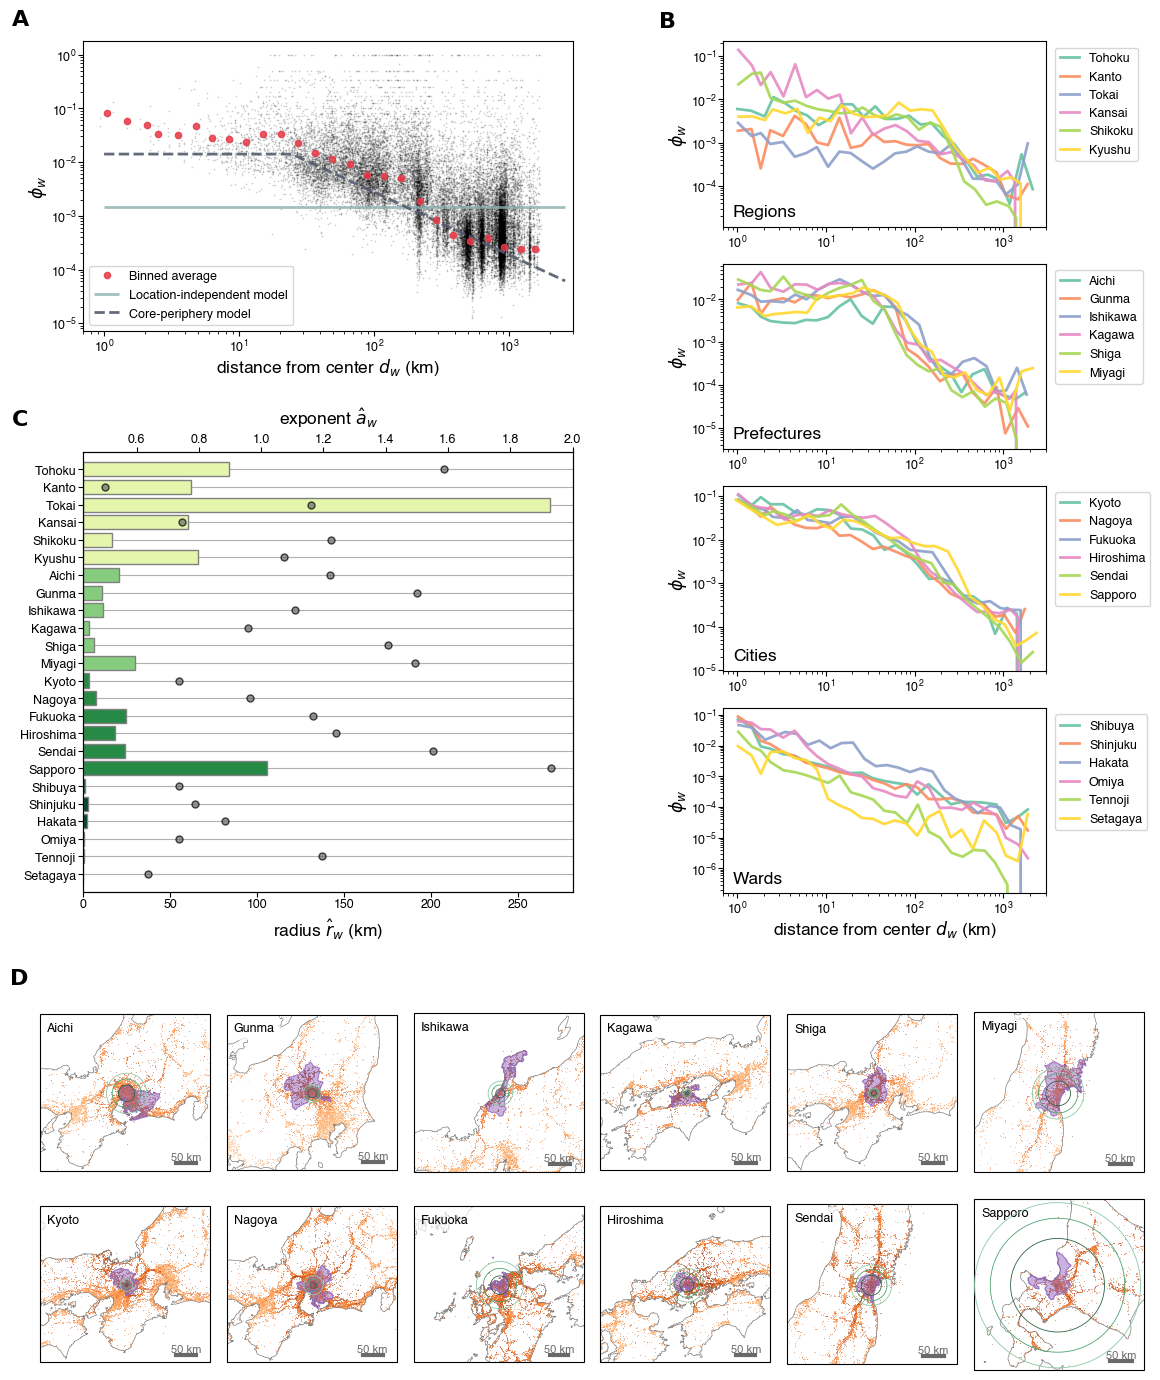

In [45]:
panel_label_kwargs = {'ha': 'left', 'va': 'bottom', 'weight': 'bold', 
                      'fontsize': PANEL_LABEL_SIZE, 'font': PANEL_LABEL_FONT}
category_colors = plt.colormaps['YlGn'](np.repeat(np.linspace(0.2, 1, 4), 6))
lim_color = '#89b0ae'
cpm_color = '#555b6e'
toponym_colors = plt.colormaps['Set2'](np.arange(6))
big_toponym = 'Fukuoka'
tick_param_kwargs = {'axis': 'both', 'which': 'major', 'labelsize': MEDIUM_FONT_SIZE, 'pad': 1.5}
scale_bar_loc = (0.8, 0.05)
scale_bar_kwargs = dict(color='dimgrey', text_kwargs={'size': SMALL_FONT_SIZE})

fig = plt.figure(figsize=(12, 14))
subfig_ABC, subfig_D = fig.subfigures(2, 1, height_ratios=[1, 0.43])
subfig_AC, subfig_B = subfig_ABC.subfigures(1, 2, width_ratios=[1.2, 1], wspace=0.03)
subfig_A, subfig_C = subfig_AC.subfigures(2, 1, height_ratios=[1, 1.4])

big_toponym_ax = subfig_A.add_subplot()
# axes2 = left_subfigs[1].subplots(1, 3, gridspec_kw={'wspace': 0.4})
axes_B = subfig_B.subplots(4, 1)
ax_rad = subfig_C.add_subplot()
axes_D = subfig_D.subplots(2, 6, subplot_kw=dict(projection=lambert_area_proj), 
                           gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

# Panel A/B
for i, category in enumerate(categories):
    names = dict_of_toponyms[category]
    ax = axes_B[i]
    ax.text(0.03, 0.04, category, transform=ax.transAxes, 
            ha='left', va='bottom', fontsize=LARGE_FONT_SIZE)
    for j, (toponym, toponym_en) in enumerate(names):
        print('Processing', toponym_en)
        data_all = all_keyword_df['tweetcount_all'].to_numpy()
        data_word = all_keyword_df['tweetcount_' + toponym_en].to_numpy()
        distance = analysis.distance_from_center(all_keyword_df, keyword=toponym_en)
        ratio = data_word / data_all
        
        logbins = np.geomspace(0.5, np.max(distance), 30)
        logbinned_distance = scipy.stats.binned_statistic(distance, distance, statistic='mean', bins=logbins).statistic
        logbinned_ratio = scipy.stats.binned_statistic(distance, ratio, statistic='mean', bins=logbins).statistic
        ax.plot(logbinned_distance, logbinned_ratio, '-', lw=2, alpha=0.9, color=toponym_colors[j], label=toponym_en)
        
        if toponym_en == big_toponym:
            big_toponym_ax.plot(distance, ratio, marker='o', ms=1.2, ls='', color='k', 
                    alpha=0.2, mec='none', rasterized=True)
            big_toponym_ax.plot(logbinned_distance, logbinned_ratio, marker='o', ms=4.5, ls='', lw=2, 
                    alpha=0.85, color='#e63946', zorder=2.5, label='Binned average')
            
            p_binom, aic_binom, bic_binom = models.binomial_mle(data_word, data_all)
            x_model = np.geomspace(1, np.max(distance), 200)
            y_model = models.core_periphery_model(x_model, near_p[big_toponym], radius[big_toponym], exponent[big_toponym])
            big_toponym_ax.hlines(p_binom, 1, np.max(distance), lw=2, color=lim_color, ls='-', 
                      label='Location-independent model', alpha=0.8)
            big_toponym_ax.plot(x_model, y_model, lw=2, color=cpm_color, ls='--', 
                    label='Core-periphery model', alpha=0.9)
            big_toponym_ax.legend(loc='lower left', fontsize=MEDIUM_FONT_SIZE)

# Panel C
flatten_toponyms = [toponym_en for names in list_of_toponyms for toponym, toponym_en in names]
radius_arr = [radius[toponym_en] for toponym_en in flatten_toponyms]
ax_rad.barh(np.arange(len(radius_arr))[::-1], radius_arr, color=category_colors, edgecolor='grey', zorder=1.6)
ax_rad.set_yticks(np.arange(len(radius_arr))[::-1], flatten_toponyms)
ax_rad.grid(axis='y', zorder=0.9)
ax_rad.set_ylim(-1, len(radius_arr))

ax_exp = ax_rad.twiny()
exponent_arr = [exponent[toponym_en] for toponym_en in flatten_toponyms]
ax_exp.plot(exponent_arr, np.arange(len(exponent_arr))[::-1], 'o', 
            color='dimgrey', ms=5, mec='k', mew=1, alpha=0.7, zorder=1.1)


# Panel D
shuffled_df = all_keyword_df.sample(frac=1, random_state=rng)
for i, (names, shape_dict) in enumerate(zip([pref_names, city_names], [pref_shape_dict, city_shape_dict])):
    for j, (toponym, toponym_en) in enumerate(names):
        print('Processing', toponym_en)
        print(f'Radius: {radius[toponym_en]:.2f} km, Exponent: {exponent[toponym_en]:.2f}')
        nonzero_df = shuffled_df[shuffled_df['tweetcount_' + toponym_en] > 0]
        data_lon = nonzero_df['longitude'].to_numpy()
        data_lat = nonzero_df['latitude'].to_numpy()
        data_val = (nonzero_df['tweetcount_' + toponym_en] / nonzero_df['tweetcount_all']).to_numpy()
        norm = mplcolors.LogNorm(vmax=np.quantile(data_val, 0.99))
        cmap = plt.get_cmap('Oranges', 8)
        center_latlon = analysis.center(nonzero_df, keyword=toponym_en)
        map_extent = (
            center_latlon[1]-lon_diff*0.1, 
            center_latlon[1]+lon_diff*0.1, 
            center_latlon[0]-lat_diff*0.08, 
            center_latlon[0]+lat_diff*0.08)
        ax = axes_D[i, j]
        map_data = mapviz.MapVisualizer(fig, extent=map_extent, projection=lambert_area_proj, 
                                        color='grey', resolution='10m', ax=ax, lw=0.5)
        map_data.visualize(data_lon, data_lat, data_val, cmap=cmap, norm=norm, 
                        size=0.4, marker=',', alpha=0.4, rasterized=True)
        toponym_text = map_data.ax.text(0.04, 0.95, toponym_en, ha='left', va='top',
                        transform=map_data.ax.transAxes, fontsize=MEDIUM_FONT_SIZE)
        toponym_text.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='none'))
        for factor, ec in zip([1, 2, 3], ['#2f6244', '#4ea472', '#8cc8a5']):
            map_data.add_circle(center_latlon[1], center_latlon[0],
                                radius[toponym_en] * 1000 * np.power(factor, 1 / exponent[toponym_en]),
                                fc='none', ec=ec, lw=0.6, zorder=4)
        if i == 0:
            shape = shape_dict[toponym_en]
        else:
            shape = shape_dict[toponym]
        shape_feature = cfeature.ShapelyFeature(shape, ccrs.PlateCarree(), 
                                                fc=mplcolors.to_rgba('tab:purple', 0.5), 
                                                ec=mplcolors.to_rgba('tab:purple', 0.8), lw=0.8)
        map_data.ax.add_feature(shape_feature)
        mapviz.scale_bar(ax=map_data.ax, location=scale_bar_loc, length=50, 
                         **scale_bar_kwargs)

for ax in [big_toponym_ax] + axes_B.tolist():
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel(r'$\phi_w$', labelpad=1.2, fontsize=LARGE_FONT_SIZE)
    ax.tick_params(**tick_param_kwargs)
    ax.set_xlim(left=0.7, right=3E3)

for ax in axes_B:
    ax.legend(loc='upper left', fontsize=MEDIUM_FONT_SIZE, bbox_to_anchor=(1.01, 1), handlelength=1.5)

for ax in [big_toponym_ax, axes_B[-1]]:
    ax.set_xlabel('distance from center ' + r'$d_w$ ' + '(km)', labelpad=0.9, fontsize=LARGE_FONT_SIZE)

ax_rad.set_xlabel('radius ' + r'$\hat{r}_w$ ' + '(km)', fontsize=LARGE_FONT_SIZE)
ax_rad.tick_params(**tick_param_kwargs)
ax_exp.set_xlabel('exponent ' + r'$\hat{a}_w$', fontsize=LARGE_FONT_SIZE, labelpad=6)
ax_exp.tick_params(**tick_param_kwargs)

# import matplotlib.patches as mpatches
# fig.add_artist(mpatches.Rectangle((0, 0), 1, 1, color='k', fill=False, lw=1))
# subfig_A.add_artist(mpatches.Rectangle((0, 0), 1, 1, color='b', fill=False, lw=1))
# subfig_C.add_artist(mpatches.Rectangle((0, 0), 1, 1, color='r', fill=False, lw=1))
# subfig_B.add_artist(mpatches.Rectangle((0, 0), 1, 1, color='g', fill=False, lw=1))
# subfig_D.add_artist(mpatches.Rectangle((0, 0), 1, 1, color='y', fill=False, lw=1))

subfig_A.subplots_adjust(top=0.88, bottom=0.17, left=0.16, right=0.92)
subfig_C.subplots_adjust(top=0.91, bottom=0.14, left=0.16, right=0.92)
subfig_B.subplots_adjust(top=0.95, bottom=0.08, left=0.15, right=0.75)
subfig_D.subplots_adjust(top=0.92, bottom=0.05, left=0.05, right=0.97)

subfig_A.text(0.05, 0.91, 'A', **panel_label_kwargs)
subfig_C.text(0.05, 0.95, 'C', **panel_label_kwargs)
subfig_B.text(0.03, 0.96, 'B', **panel_label_kwargs)
subfig_D.text(0.025, 0.96, 'D', **panel_label_kwargs)

In [46]:
fig.savefig(os.path.join(figdir, 'core_periphery.pdf'), bbox_inches='tight')

4.000864864864865


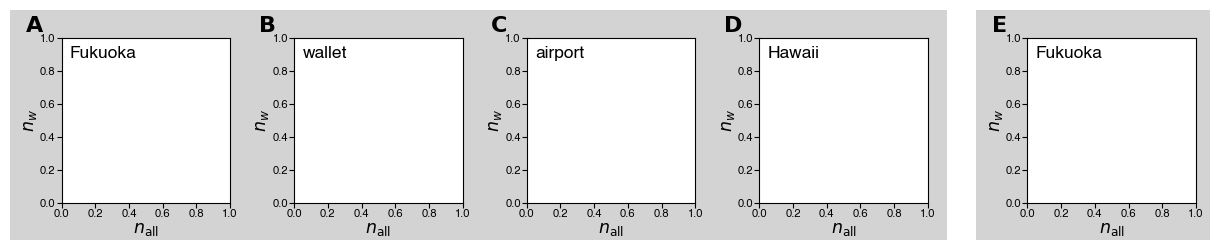

In [63]:
panel_label_kwargs = {'ha': 'left', 'va': 'bottom', 'weight': 'bold',
                        'fontsize': PANEL_LABEL_SIZE, 'font': PANEL_LABEL_FONT}
fig = plt.figure(figsize=(12, 2.3))
# fig.add_artist(mpatches.Rectangle((0, 0), 1, 1, color='k', fill=False, lw=1))
delta = 0.38
lr_A = 0.925
lr_B = 0.72
left_A = 0.055
left_B = 0.22
AB_width_ratio = (4 + 3 * delta) * lr_B / lr_A 
print(AB_width_ratio)
subfig_A, subfig_B = fig.subfigures(1, 2, wspace=0.05, width_ratios=[AB_width_ratio, 1])

subfig_A.add_artist(mpatches.Rectangle((0, 0), 1, 1, facecolor='lightgray', fill=True, 
                                       edgecolor='none', lw=1, zorder=0))
subfig_B.add_artist(mpatches.Rectangle((0, 0), 1, 1, facecolor='lightgray', fill=True, 
                                       edgecolor='none', lw=1, zorder=0))

example_words = ['Fukuoka', 'wallet', 'airport', 'Hawaii']
axes_binomial = subfig_A.subplots(1, len(example_words), gridspec_kw={'wspace': delta})
ax_coreperi = subfig_B.add_subplot()

subfig_A.subplots_adjust(left=left_A, right=left_A+lr_A, top=0.88, bottom=0.16)
subfig_B.subplots_adjust(left=left_B, right=left_B+lr_B, top=0.88, bottom=0.16)

for ax, word_en, panel_label in zip(axes_binomial, example_words, ['A', 'B', 'C', 'D']):
    ax.text(0.05, 0.95, word_en, ha='left', va='top',
            transform=ax.transAxes, fontsize=LARGE_FONT_SIZE)
    ax.text(-0.21, 1.01, panel_label, **panel_label_kwargs)

ax_coreperi.text(0.05, 0.95, 'Fukuoka', ha='left', va='top', 
                 transform=ax_coreperi.transAxes, fontsize=LARGE_FONT_SIZE)
ax_coreperi.text(-0.21, 1.01, 'E', **panel_label_kwargs)

for ax in axes_binomial.tolist() + [ax_coreperi]:
    ax.set_xlabel('$n_\mathrm{all}$', labelpad=1, fontsize=LARGE_FONT_SIZE)
    ax.set_ylabel('$n_w$', labelpad=0.8, fontsize=LARGE_FONT_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=SMALL_FONT_SIZE, pad=0.8)

# subfig_A.text(0.01, 0.89, 'A', **panel_label_kwargs)
# subfig_B.text(0.03, 0.89, 'B', **panel_label_kwargs)

4.000864864864865


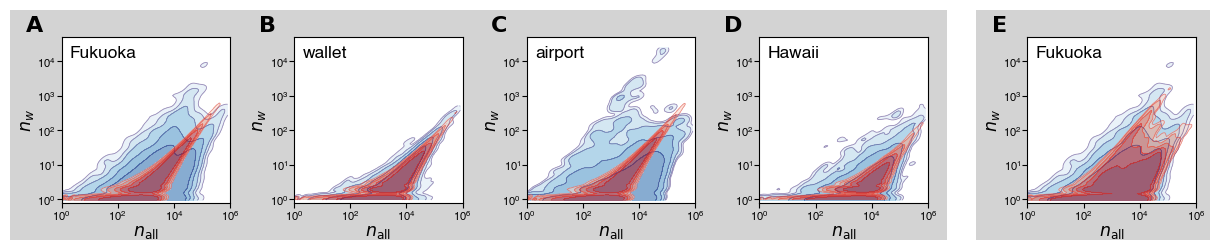

In [64]:
panel_label_kwargs = {'ha': 'left', 'va': 'bottom', 'weight': 'bold',
                        'fontsize': PANEL_LABEL_SIZE, 'font': PANEL_LABEL_FONT}
fig = plt.figure(figsize=(12, 2.3))
# fig.add_artist(mpatches.Rectangle((0, 0), 1, 1, color='k', fill=False, lw=1))
delta = 0.38
lr_A = 0.925
lr_B = 0.72
left_A = 0.055
left_B = 0.22
AB_width_ratio = (4 + 3 * delta) * lr_B / lr_A 
print(AB_width_ratio)
subfig_A, subfig_B = fig.subfigures(1, 2, wspace=0.05, width_ratios=[AB_width_ratio, 1])

subfig_A.add_artist(mpatches.Rectangle((0, 0), 1, 1, facecolor='lightgray', fill=True, 
                                       edgecolor='none', lw=1, zorder=0))
subfig_B.add_artist(mpatches.Rectangle((0, 0), 1, 1, facecolor='lightgray', fill=True, 
                                       edgecolor='none', lw=1, zorder=0))

example_words = ['Fukuoka', 'wallet', 'airport', 'Hawaii']
axes_binomial = subfig_A.subplots(1, len(example_words), gridspec_kw={'wspace': delta})
ax_coreperi = subfig_B.add_subplot()

subfig_A.subplots_adjust(left=left_A, right=left_A+lr_A, top=0.88, bottom=0.16)
subfig_B.subplots_adjust(left=left_B, right=left_B+lr_B, top=0.88, bottom=0.16)

for ax, word_en, panel_label in zip(axes_binomial, example_words, ['A', 'B', 'C', 'D']):
    contour_plot_all_vs_keyword_binomial(ax, all_keyword_df, word_en, 
                                         rng=rng, p_binomial=p_binomial)
    ax.text(0.05, 0.95, word_en, ha='left', va='top',
            transform=ax.transAxes, fontsize=LARGE_FONT_SIZE)
    ax.text(-0.21, 1.01, panel_label, 
            transform=ax.transAxes, **panel_label_kwargs)

contour_plot_all_vs_keyword_coreperi(ax_coreperi, all_keyword_df, 'Fukuoka', 
                                     rng=rng, near_p=near_p, radius=radius, exponent=exponent)
ax_coreperi.text(0.05, 0.95, 'Fukuoka', ha='left', va='top', 
                 transform=ax_coreperi.transAxes, fontsize=LARGE_FONT_SIZE)
ax_coreperi.text(-0.21, 1.01, 'E', 
                 transform=ax_coreperi.transAxes, **panel_label_kwargs)

for ax in axes_binomial.tolist() + [ax_coreperi]:
    ax.set_xlabel('$n_\mathrm{all}$', labelpad=1, fontsize=LARGE_FONT_SIZE)
    ax.set_ylabel('$n_w$', labelpad=0.8, fontsize=LARGE_FONT_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=SMALL_FONT_SIZE, pad=0.8)

# subfig_A.text(0.01, 0.89, 'A', **panel_label_kwargs)
# subfig_B.text(0.03, 0.89, 'B', **panel_label_kwargs)

In [65]:
fig.savefig(os.path.join(figdir, 'all_tweets_vs_toponym_subsample_example.pdf'), bbox_inches='tight')

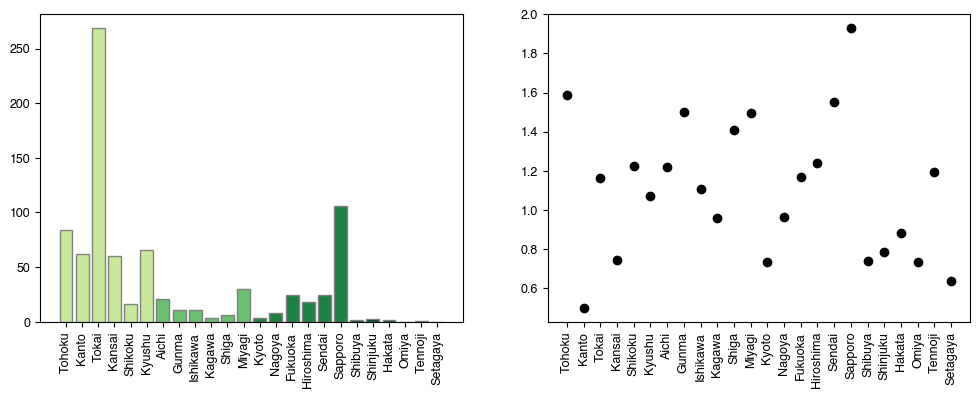

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
total_count_toponyms_arr = [total_counts[toponym_en] for names in list_of_toponyms for toponym, toponym_en in names]
flatten_toponyms = [toponym_en for names in list_of_toponyms for toponym, toponym_en in names]
colors = plt.colormaps['YlGn'](np.repeat(np.linspace(0.3, 1, 4), 6))

radius_arr = [radius[toponym_en] for toponym_en in flatten_toponyms]
# axes[0].plot(np.arange(len(radius_arr)), radius_arr, 'o', color='k')
axes[0].bar(np.arange(len(radius_arr)), radius_arr, color=colors, edgecolor='grey')
axes[0].set_xticks(np.arange(len(radius_arr)), flatten_toponyms, rotation=90)
# axes[0].set_ylim(top=110)

exponent_arr = [exponent[toponym_en] for toponym_en in flatten_toponyms]
axes[1].plot(np.arange(len(exponent_arr)), exponent_arr, 'o', color='k')
axes[1].set_xticks(np.arange(len(exponent_arr)), flatten_toponyms, rotation=90)

    # ax.plot(total_count_toponyms_arr, param_arr, 'o', ms=3, color='k', mec='k', mew=1, alpha=0.5)
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # ax.tick_params(axis='both', which='major', labelsize=SMALL_FONT_SIZE)

Text(0.5, 0, 'exponent $a_w$')

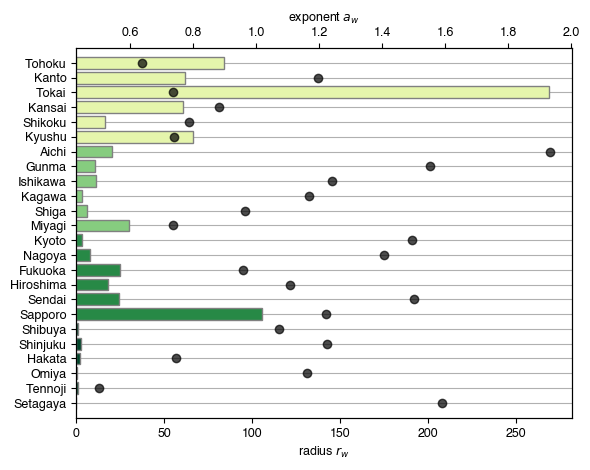

In [61]:
fig, ax_rad = plt.subplots()

flatten_toponyms = [toponym_en for names in list_of_toponyms for toponym, toponym_en in names]
colors = plt.colormaps['YlGn'](np.repeat(np.linspace(0.2, 1, 4), 6))
radius_arr = [radius[toponym_en] for toponym_en in flatten_toponyms]
ax_rad.barh(np.arange(len(radius_arr))[::-1], radius_arr, color=colors, edgecolor='grey', zorder=1.6)
ax_rad.set_yticks(np.arange(len(radius_arr))[::-1], flatten_toponyms)
ax_rad.grid(axis='y', zorder=0.9)
ax_rad.set_ylim(-1, len(radius_arr))
ax_rad.set_xlabel('radius ' + r'$r_w$')

ax_exp = ax_rad.twiny()
exponent_arr = [exponent[toponym_en] for toponym_en in flatten_toponyms]
ax_exp.plot(exponent_arr, np.arange(len(exponent_arr)), 'o', 
    color='k', mec='k', mew=1, alpha=0.7, zorder=1.1)
ax_exp.set_xlabel('exponent ' + r'$a_w$')

In [62]:
total_counts_outside_core = {}
for category, keywords in dict_of_keywords.items():
    for keyword_jp, keyword_en in keywords:
        distance = analysis.distance_from_center(all_keyword_df, keyword=toponym_en)
        count = all_keyword_df[distance > radius[toponym_en]]['tweetcount_' + keyword_en].sum()
        total_counts_outside_core[keyword_en] = count

-0.3252115150205441 0.12098498305998505


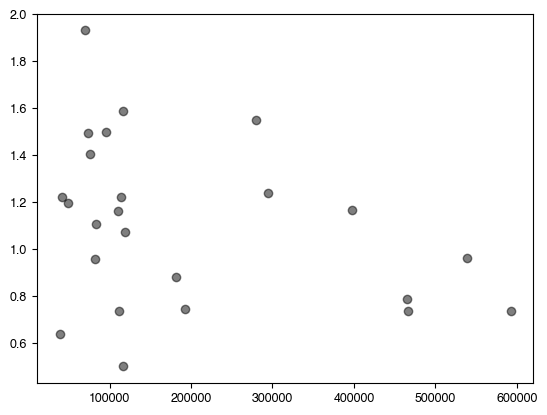

In [63]:
fig, ax = plt.subplots()
exponent_arr = [exponent[toponym_en] for toponym_en in flatten_toponyms]
count_outside_core_arr = [total_counts_outside_core[toponym_en] for toponym_en in flatten_toponyms]
ax.plot(count_outside_core_arr, exponent_arr, 'o', color='k', mec='k', mew=1, alpha=0.5)
# ax.set_xscale('log')

# Correlation coefficient
r, p = scipy.stats.pearsonr(count_outside_core_arr, exponent_arr)
print(r, p)

Processing Tohoku
Processing Kanto
Processing Tokai
Processing Kansai
Processing Shikoku
Processing Kyushu
Processing Aichi
Processing Gunma
Processing Ishikawa
Processing Kagawa
Processing Shiga
Processing Miyagi
Processing Kyoto
Processing Nagoya
Processing Fukuoka
Processing Hiroshima
Processing Sendai
Processing Sapporo
Processing Shibuya
Processing Shinjuku
Processing Hakata
Processing Omiya
Processing Tennoji
Processing Setagaya


(array([<matplotlib.figure.SubFigure object at 0x3064ca810>,
        <matplotlib.figure.SubFigure object at 0x302ff2910>], dtype=object),
 [array([<Axes: xlabel='$n_\\mathrm{all}$', ylabel='$n_w$'>,
         <Axes: xlabel='$n_\\mathrm{all}$'>,
         <Axes: xlabel='$n_\\mathrm{all}$'>,
         <Axes: xlabel='$n_\\mathrm{all}$'>,
         <Axes: xlabel='$n_\\mathrm{all}$'>,
         <Axes: xlabel='$n_\\mathrm{all}$'>], dtype=object),
  array([<Axes: xlabel='$n_\\mathrm{all}$', ylabel='$n_w$'>,
         <Axes: xlabel='$n_\\mathrm{all}$'>,
         <Axes: xlabel='$n_\\mathrm{all}$'>,
         <Axes: xlabel='$n_\\mathrm{all}$'>,
         <Axes: xlabel='$n_\\mathrm{all}$'>,
         <Axes: xlabel='$n_\\mathrm{all}$'>], dtype=object),
  array([<Axes: xlabel='$n_\\mathrm{all}$', ylabel='$n_w$'>,
         <Axes: xlabel='$n_\\mathrm{all}$'>,
         <Axes: xlabel='$n_\\mathrm{all}$'>,
         <Axes: xlabel='$n_\\mathrm{all}$'>,
         <Axes: xlabel='$n_\\mathrm{all}$'>,
         <Axes: x

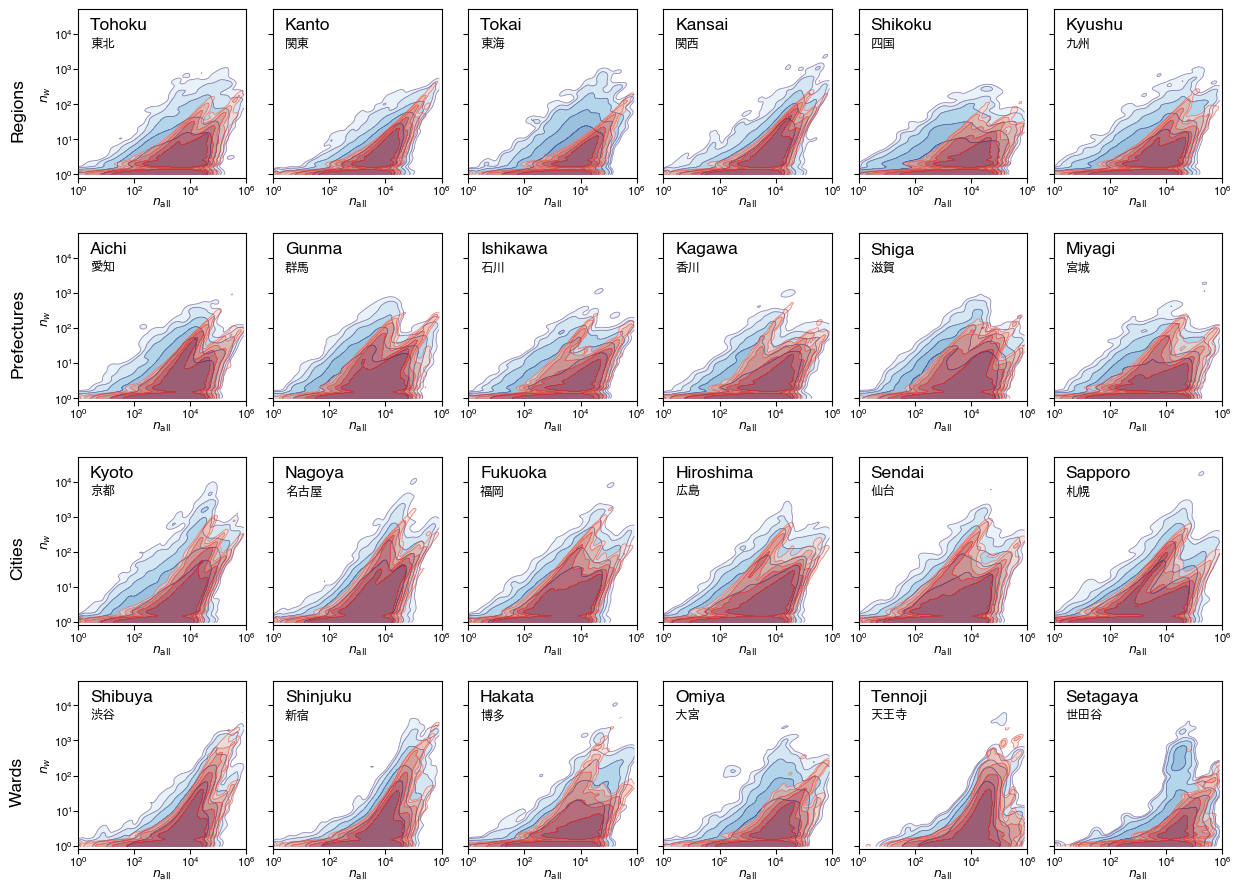

In [58]:
dict_of_toponyms = {'Regions': region_names, 'Prefectures': pref_names, 
                    'Cities': city_names, 'Wards': district_names}

nrows = len(dict_of_toponyms)
fig = plt.figure(figsize=(12, 2.2*nrows), layout='constrained')
plot_all_vs_many_keywords2(fig, all_keyword_df, dict_of_toponyms,
                           model='coreperi', rng=rng, near_p=near_p, radius=radius, exponent=exponent)
                           

In [59]:
fig.savefig(os.path.join(figdir, 'all_tweets_vs_toponym_subsample_many_coreperi.pdf'),
            dpi=300, bbox_inches='tight')

In [60]:
aic_bic_df = pd.DataFrame.from_dict(aic_binomial, orient='index', columns=['AIC binomial'])
aic_bic_df['BIC binomial'] = bic_binomial
aic_bic_df['AIC core-periphery'] = aic_coreperi
aic_bic_df['BIC core-periphery'] = bic_coreperi

In [61]:
aic_bic_df

AIC binomial   BIC binomial  AIC core-periphery  \
Tohoku      272071.544827  272082.153742       181592.673489   
Kanto       215549.038428  215559.647343       183055.799421   
Tokai       232899.248205  232909.857119       190583.208946   
Kansai      277788.760574  277799.369488       203043.949857   
Shikoku     155277.670933  155288.279847       119925.128381   
Kyushu      271555.697125  271566.306040       200052.004218   
Aichi       280476.690259  280487.299174       170583.059231   
Gunma       249747.704139  249758.313053       150798.757102   
Ishikawa    193227.174745  193237.783660       156757.710940   
Kagawa      195854.349527  195864.958441       157588.783010   
Shiga       200151.175011  200161.783925       122490.760432   
Miyagi      205465.992484  205476.601398       126508.740786   
Kyoto       670791.900023  670802.508937       289137.943783   
Nagoya      673067.697822  673078.306737       291761.629834   
Fukuoka     610868.583246  610879.192160       277299.110409   
Hiroshima   459053.540349  459064.149263       264035.257984   
Sendai      487769.582633  487780.191547       193919.691030   
Sapporo     486788.868213  486799.477128       171991.342434   
Shibuya     567599.461168  567610.070082       134636.151169   
Shinjuku    590732.338531  590742.947446       127634.524575   
Hakata      301253.351206  301263.960120       132902.512482   
Omiya       211210.847197  211221.456111       117914.034847   
Tennoji     105225.932279  105236.541194        32176.923538   
Setagaya     77534.251792   77544.860706        33096.806850   
telephone   526027.216916  526037.825830                 NaN   
music       313954.841165  313965.450079                 NaN   
vegetable   311366.096813  311376.705727                 NaN   
society     278030.879277  278041.488191                 NaN   
wallet      208194.815330  208205.424244                 NaN   
reason      210864.521810  210875.130724                 NaN   
trip        497102.734027  497113.342941                 NaN   
park        976730.151782  976740.760696                 NaN   
university  553289.598017  553300.206932                 NaN   
hotel       577996.561785  578007.170699                 NaN   
airport     555523.753294  555534.362208                 NaN   
shrine      508608.448962  508619.057876                 NaN   
Hawaii      144820.837118  144831.446032                 NaN   
Dubai       141592.578822  141603.187736                 NaN   
Hong Kong    62225.345135   62235.954049                 NaN   
New York     53520.022120   53530.631034                 NaN   
Singapore    53659.223359   53669.832274                 NaN   
Seoul       118131.725247  118142.334161                 NaN   

            BIC core-periphery  
Tohoku           181624.500232  
Kanto            183087.626164  
Tokai            190615.035689  
Kansai           203075.776600  
Shikoku          119956.955124  
Kyushu           200083.830961  
Aichi            170614.885974  
Gunma            150830.583845  
Ishikawa         156789.537683  
Kagawa           157620.609753  
Shiga            122522.587175  
Miyagi           126540.567529  
Kyoto            289169.770526  
Nagoya           291793.456577  
Fukuoka          277330.937152  
Hiroshima        264067.084727  
Sendai           193951.517773  
Sapporo          172023.169177  
Shibuya          134667.977912  
Shinjuku         127666.351318  
Hakata           132934.339225  
Omiya            117945.861590  
Tennoji           32208.750281  
Setagaya          33128.633593  
telephone                  NaN  
music                      NaN  
vegetable                  NaN  
society                    NaN  
wallet                     NaN  
reason                     NaN  
trip                       NaN  
park                       NaN  
university                 NaN  
hotel                      NaN  
airport                    NaN  
shrine                     NaN  
Hawaii                     NaN  
Dubai 

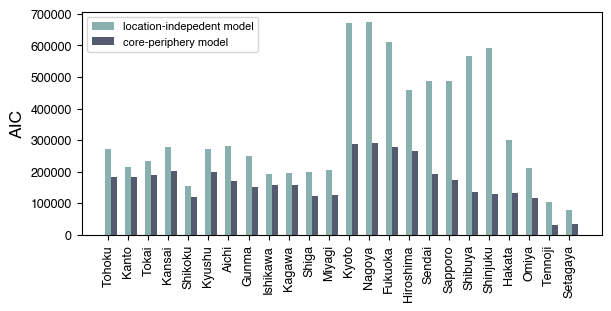

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), layout='constrained')
x = np.arange(len(aic_coreperi))
width = 0.3
multiplier = 0
toponyms = region_names + pref_names + city_names + district_names

lim_color = '#89b0ae' # '#2a9d8f' # '#BCA3CA' # '#a8dadc'
cpm_color = '#555b6e' # '#264653' # '#CCF0C3' # '#e63946'

# ax = axes[0]
ax.bar(x, [aic_binomial[toponym_en] for toponym, toponym_en in toponyms], width, 
       label='location-indepedent model', color=lim_color)
ax.bar(x + width, [aic_coreperi[toponym_en] for toponym, toponym_en in toponyms], width, 
       label='core-periphery model', color=cpm_color)
ax.set_xticks(x, [toponym_en for toponym, toponym_en in toponyms], rotation=90)
ax.set_ylabel('AIC', fontsize=LARGE_FONT_SIZE)
ax.legend(fontsize=SMALL_FONT_SIZE)

# ax = axes[1]
# ax.bar(x, [bic_binomial[toponym_en] for toponym, toponym_en in toponyms], width, 
#        label='location-indepedent model', color=sim_color)
# ax.bar(x + width, [bic_coreperi[toponym_en] for toponym, toponym_en in toponyms], width,
#        label='center-periphery model', color=sdm_color)
# ax.set_xticks(x, [toponym_en for toponym, toponym_en in toponyms], rotation=90)
# ax.set_ylabel('BIC', fontsize=LARGE_FONT_SIZE)
# ax.legend(fontsize=SMALL_FONT_SIZE)

In [69]:
# fig.savefig(os.path.join(figdir, 'aic_comparison.pdf'), bbox_inches='tight')

In [70]:
%%script false --no-raise-error
fig = plt.figure(figsize=(12, 4), layout='constrained')
axes = fig.subplots(2, 6, subplot_kw=dict(projection=lambert_area_proj))
# fig, axes = plt.subplots(1, 6, figsize=(18, 4), layout='constrained', projection=lambert_area_proj)
shuffled_df = all_keyword_df.sample(frac=1, random_state=rng)
scale_bar_loc = (0.8, 0.05)
scale_bar_kwargs = dict(color='dimgrey', text_kwargs={'size': SMALL_FONT_SIZE})
for i, (names, shape_dict) in enumerate(zip([pref_names, city_names], [pref_shape_dict, city_shape_dict])):
    for j, (toponym, toponym_en) in enumerate(names):
        print('Processing', toponym_en)
        print(f'Radius: {radius[toponym_en]:.2f} km, Exponent: {exponent[toponym_en]:.2f}')
        nonzero_df = shuffled_df[shuffled_df['tweetcount_' + toponym_en] > 0]
        data_lon = nonzero_df['longitude'].to_numpy()
        data_lat = nonzero_df['latitude'].to_numpy()
        data_val = (nonzero_df['tweetcount_' + toponym_en] / nonzero_df['tweetcount_all']).to_numpy()
        norm = mplcolors.LogNorm(vmax=np.quantile(data_val, 0.99))
        cmap = plt.get_cmap('Oranges', 8)
        center_latlon = analysis.center(nonzero_df, keyword=toponym_en)
        map_extent = (
            center_latlon[1]-lon_diff*0.1, 
            center_latlon[1]+lon_diff*0.1, 
            center_latlon[0]-lat_diff*0.08, 
            center_latlon[0]+lat_diff*0.08)
        ax = axes[i, j]
        map_data = mapviz.MapVisualizer(fig, extent=map_extent, projection=lambert_area_proj, 
                                        color='grey', resolution='10m', ax=ax, lw=0.5)
        map_data.visualize(data_lon, data_lat, data_val, cmap=cmap, norm=norm, 
                        size=0.4, marker=',', alpha=0.4)
        # map_data.add_colorbar(cblabel=cblabel, orientation='horizontal')
        toponym_text = map_data.ax.text(0.04, 0.95, toponym_en, ha='left', va='top',
                        transform=map_data.ax.transAxes, fontsize=MEDIUM_FONT_SIZE)
        toponym_text.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='none'))
        # map_data.ax.plot(center_latlon[1], center_latlon[0], 'o', color='k', 
        #                  markersize=2, mec='none', 
        #                  transform=ccrs.PlateCarree(), zorder=4.1)
        for factor, ec in zip([1, 2, 3], ['#2f6244', '#4ea472', '#8cc8a5']):
            map_data.add_circle(center_latlon[1], center_latlon[0],
                                radius[toponym_en] * 1000 * np.power(factor, 1 / exponent[toponym_en]),
                                fc='none', ec=ec, lw=0.6, zorder=4)

        # map_data.add_circle(center_latlon[1], center_latlon[0], 
        #                     radius[toponym] * 1000, 
        #                     # fc=mplcolors.to_rgba('tab:blue', 0.3), 
        #                     fc='none', ec='k', zorder=5, lw=0.8)
        # map_data.add_circle(center_latlon[1], center_latlon[0], 
        #                     radius[toponym] * 1000 * 2**(1 / exponent[toponym]), 
        #                     fc='none', ec='grey', zorder=5, lw=0.8)
        
        
        if i == 0:
            shape = shape_dict[toponym_en]
        else:
            shape = shape_dict[toponym]
        shape_feature = cfeature.ShapelyFeature(shape, ccrs.PlateCarree(), 
                                                fc=mplcolors.to_rgba('tab:purple', 0.5), 
                                                ec=mplcolors.to_rgba('tab:purple', 0.8), lw=0.8)
        map_data.ax.add_feature(shape_feature)
        mapviz.scale_bar(ax=map_data.ax, location=scale_bar_loc, length=50, 
                         **scale_bar_kwargs)

In [71]:
# fig.savefig(os.path.join(figdir, 'comparison_radius_area.png'), dpi=300, bbox_inches='tight')